<a href="https://colab.research.google.com/github/shoreey/London-Fire-Brigade-Data-Analysis/blob/main/London_Fire_Birgade_Data_Mining_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
import joblib
import pickle
from scipy.stats import kendalltau

# Setting Seaborn style as default
#Set Seaborn style to whitegrid

In [ ]:
sns.set()
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

# DATA UNDERSTANDING

# LOAD DATA

In [ ]:
df = pd.read_excel("E:\London.xlsx")
df.head(5)

IncidentNumber   DateOfCall  CalYear TimeOfCall  HourOfCall  \
0  000006-01012019  01 Jan 2019     2019   00:01:45           0   
1  000019-01012019  01 Jan 2019     2019   00:04:33           0   
2  000020-01012019  01 Jan 2019     2019   00:04:39           0   
3  000021-01012019  01 Jan 2019     2019   00:04:44           0   
4  000024-01012019  01 Jan 2019     2019   00:05:00           0   

     IncidentGroup        StopCodeDescription SpecialServiceType  \
0  Special Service            Special Service       Lift Release   
1             Fire             Secondary Fire                NaN   
2      False Alarm  False alarm - Good intent                NaN   
3      False Alarm                        AFA                NaN   
4  Special Service            Special Service       Lift Release   

  PropertyCategory                                       PropertyType  \
0         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
1          Outdoor                                        Tree scrub    
2          Outdoor        Domestic garden (vegetation not equipment)    
3         Dwelling             Stately Home (part not open to public)   
4         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    

                       AddressQualifier Postcode_full Postcode_district  \
0             Correct incident location           NaN              SE11   
1      On land associated with building        N9 7HU                N9   
2  In street outside gazetteer location       N20 0BB               N20   
3                  Within same building           NaN               SW7   
4             Correct incident location           NaN                E3   

        UPRN      USRN IncGeo_BoroughCode IncGeo_BoroughName     ProperCase  \
0          0  21901674          E09000022            LAMBETH        Lambeth   
1  207088775  20704497          E09000010            ENFIELD        Enfield   
2  200100401  20037660          E09000003             BARNET         Barnet   
3          0   8400731          E09000033        WESTMINSTER    Westminster   
4          0  22700484          E09000030      TOWER HAMLETS  Tower Hamlets   

  IncGeo_WardCode            IncGeo_WardName         IncGeo_WardNameNew  \
0       E05014105                 Kennington                 Kennington   
1       E05013685             Lower Edmonton             Lower Edmonton   
2       E05013629             Brunswick Park             Brunswick Park   
3       E05013797  Knightsbridge & Belgravia  Knightsbridge & Belgravia   
4       E05009319                   Bow East                   Bow East   

   Easting_m  Northing_m  Easting_rounded  Northing_rounded   Latitude  \
0        NaN         NaN           530850            178650        NaN   
1   534494.0    194099.0           534450            194050  51.629641   
2   527630.0    193922.0           527650            193950  51.629649   
3        NaN         NaN           526750            179550        NaN   
4        NaN         NaN           537250            183250        NaN   

   Longitude     FRS IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0        NaN  London               Lambeth                               NaN   
1  -0.058219  London              Edmonton                             357.0   
2  -0.157400  London                Barnet                             318.0   
3        NaN  London            Kensington                             210.0   
4        NaN  London                Poplar                             329.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                                   NaN                                NaN   
1                              Edmonton                                NaN   
2                             Southgate                                NaN   
3                            Kensington                                NaN   
4                         Bethnal Green                     

# Selecting the Borough that has been assigned

In [ ]:
CityOfLondon = df[df['IncGeo_BoroughName'] =='CITY OF LONDON']
CityOfLondon.to_csv('E:\CityOfLondon.csv', index =False)
CityOfLondon = pd.read_csv('E:\CityOfLondon.csv')

# Describe City Of London other Boroughs

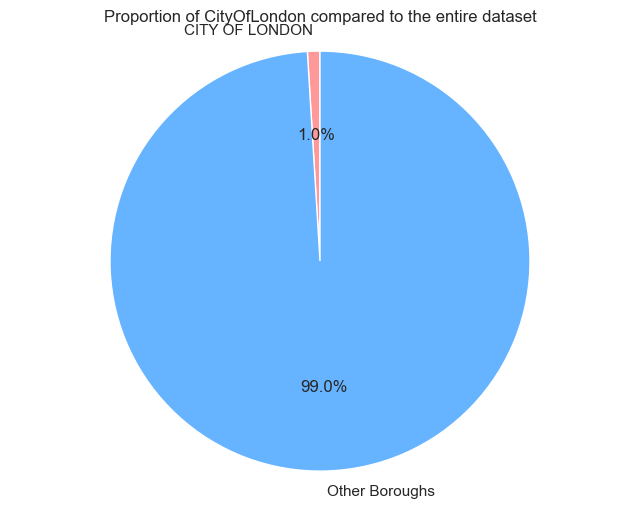

In [ ]:
# Calculate the percentage of CityOfLondon compared to the total dataset
percentage = round((len(CityOfLondon) / len(df)), 4) * 100
other_percentage = 100 - percentage

# Construct the representation
labels = ['CITY OF LONDON', 'Other Boroughs']
sizes = [percentage, other_percentage]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of CityOfLondon compared to the entire dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


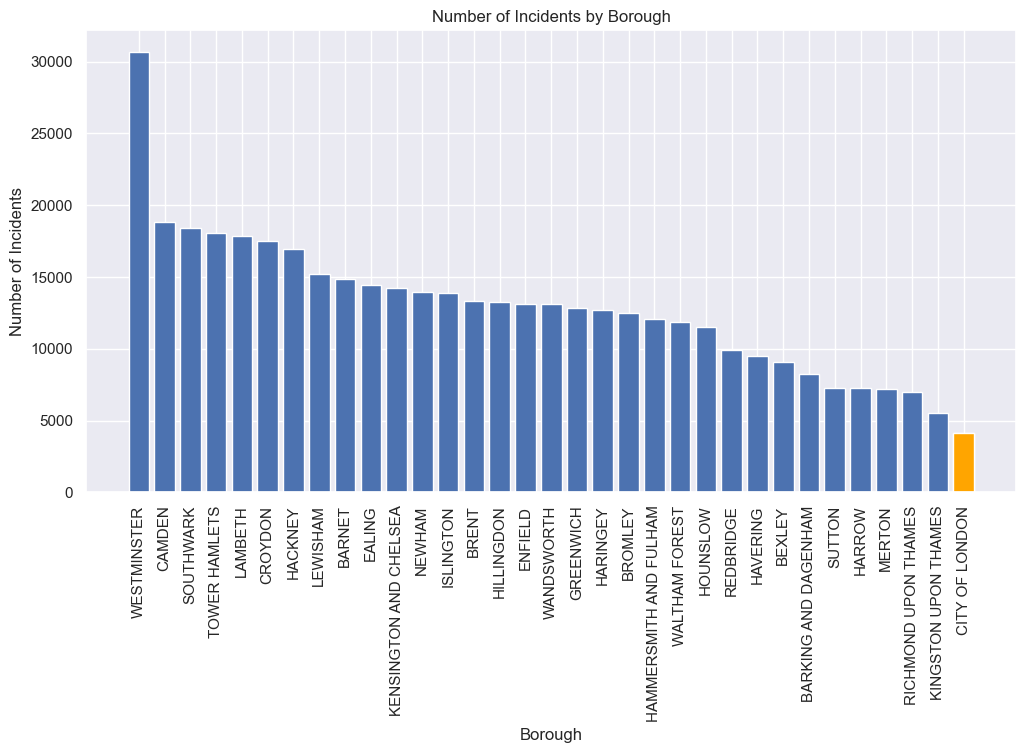

In [ ]:
# Count number of incidents per borough
borough_counts = df['IncGeo_BoroughName'].value_counts()

# Create a bar plot of incident counts for each borough
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(borough_counts.index, borough_counts.values)

# Highlight City of London in a different color
ax.bar('CITY OF LONDON', borough_counts.loc['CITY OF LONDON'], color='orange')

# Set plot title and axis labels
ax.set_title('Number of Incidents by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Number of Incidents')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()


# Checking correlation between all the columns

Correlation Matrix:
                                    CalYear  HourOfCall      UPRN      USRN  \
CalYear                            1.000000   -0.005833 -0.043150  0.018063   
HourOfCall                        -0.005833    1.000000 -0.005381 -0.002079   
UPRN                              -0.043150   -0.005381  1.000000 -0.037139   
USRN                               0.018063   -0.002079 -0.037139  1.000000   
Easting_m                          0.046421    0.001337 -0.025119  0.016969   
Northing_m                        -0.007304   -0.005342  0.040514  0.071760   
Easting_rounded                    0.041815    0.001551 -0.027921  0.014831   
Northing_rounded                  -0.000085    0.001997 -0.015408  0.062457   
Latitude                           0.008424    0.013945  0.005524  0.002105   
Longitude                          0.040445   -0.004695 -0.024801  0.015857   
FirstPumpArriving_AttendanceTime  -0.044541   -0.067776 -0.022107  0.005872   
SecondPumpArriving_AttendanceTim

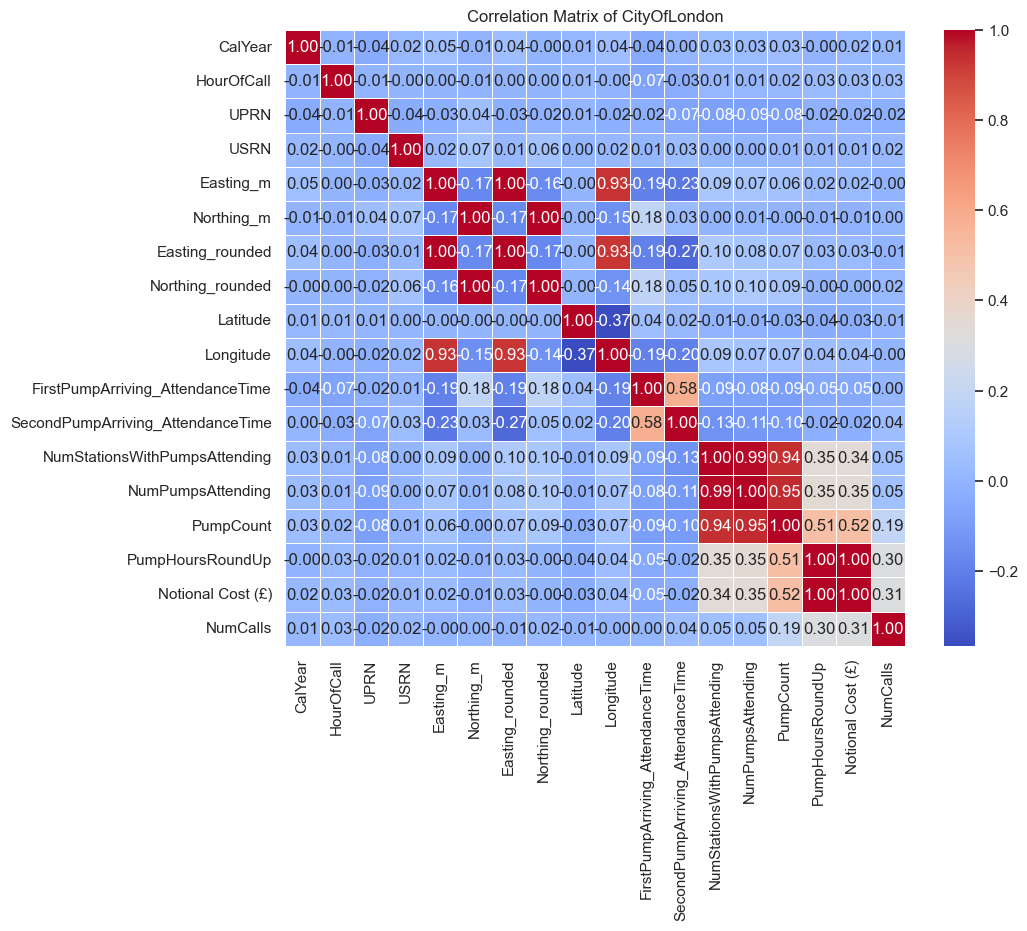

In [ ]:
# Select only numeric columns
numeric_columns = CityOfLondon.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of CityOfLondon')
plt.show()


# Checking the DataTypes

In [ ]:
print(CityOfLondon.dtypes)


IncidentNumber                             object
DateOfCall                                 object
CalYear                                     int64
TimeOfCall                                 object
HourOfCall                                  int64
IncidentGroup                              object
StopCodeDescription                        object
SpecialServiceType                         object
PropertyCategory                           object
PropertyType                               object
AddressQualifier                           object
Postcode_full                              object
Postcode_district                          object
UPRN                                        int64
USRN                                        int64
IncGeo_BoroughCode                         object
IncGeo_BoroughName                         object
ProperCase                                 object
IncGeo_WardCode                            object
IncGeo_WardName                            object


In [ ]:
# Get columns with data type 'object'
object_columns = CityOfLondon.select_dtypes(include='object').columns.tolist()

# Get columns with data type 'float64'
float64_columns = CityOfLondon.select_dtypes(include='float64').columns.tolist()

# Get columns with data type 'int64'
int64_columns = CityOfLondon.select_dtypes(include='int64').columns.tolist()

# Print the column lists
print('Object columns:', object_columns)
print('Float columns:', float64_columns)
print('Int columns:', int64_columns)


Object columns: ['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation']
Float columns: ['Easting_m', 'Northing_m', 'Latitude', 'Longitude', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']
Int columns: ['CalYear', 'HourOfCall', 'UPRN', 'USRN', 'Easting_rounded', 'Northing_rounded']


# concatenating Numerical columns into one variable

In [ ]:
numerical_columns = float64_columns + int64_columns
print(numerical_columns)


['Easting_m', 'Northing_m', 'Latitude', 'Longitude', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls', 'CalYear', 'HourOfCall', 'UPRN', 'USRN', 'Easting_rounded', 'Northing_rounded']


In [ ]:
CityOfLondon[numerical_columns].describe()

Easting_m     Northing_m     Latitude    Longitude  \
count    3694.000000    3694.000000  3694.000000  3694.000000   
mean   532544.136167  181219.805901    51.416748    -0.091059   
std       702.366024     302.541750     2.240661     0.010844   
min    531031.000000  180425.000000     0.000000    -0.112884   
25%    532009.250000  180987.000000    51.512223    -0.098824   
50%    532678.000000  181190.000000    51.514151    -0.089226   
75%    533098.000000  181457.000000    51.516591    -0.083274   
max    533817.000000  182112.000000    51.522487     0.000000   

       FirstPumpArriving_AttendanceTime  SecondPumpArriving_AttendanceTime  \
count                       3870.000000                         784.000000   
mean                         278.095607                         335.469388   
std                          109.517026                         109.180316   
min                            1.000000                           6.000000   
25%                          215.000000                         275.750000   
50%                          263.000000                         317.000000   
75%                          322.000000                         368.250000   
max                         1165.000000                        1119.000000   

       NumStationsWithPumpsAttending  NumPumpsAttending    PumpCount  \
count                    4070.000000        4070.000000  4071.000000   
mean                        1.435872           1.460442     1.488332   
std                         1.047972           1.093911     1.177512   
min                         1.000000           1.000000     1.000000   
25%                         1.000000           1.000000     1.000000   
50%                         1.000000           1.000000     1.000000   
75%                         1.000000           1.000000     1.000000   
max                         6.000000           6.000000    19.000000   

       PumpHoursRoundUp  Notional Cost (£)     NumCalls      CalYear  \
count       4070.000000        4070.000000  4109.000000  4110.000000   
mean           1.242506         431.811794     1.194451  2020.388808   
std            1.240312         434.094799     0.642846     1.156177   
min            1.000000         333.000000     1.000000  2019.000000   
25%            1.000000         339.000000     1.000000  2019.000000   
50%            1.000000         346.000000     1.000000  2020.000000   
75%            1.000000         364.000000     1.000000  2021.000000   
max           36.000000       13104.000000    18.000000  2022.000000   

        HourOfCall          UPRN          USRN  Easting_rounded  \
count  4110.000000  4.110000e+03  4.110000e+03      4110.000000   
mean     12.384672  6.476419e+10  8.126672e+06    532550.802920   
std       5.979621  7.243114e+10  5.986297e+05       706.856754   
min       0.000000  0.000000e+00  8.100007e+06    531050.000000   
25%       8.000000  9.551062e+07  8.100150e+06    532050.000000   
50%      12.000000  1.009199e+10  8.100301e+06    532650.000000   
75%      17.000000  1.000229e+11  8.100440e+06    533150.000000   
max      23.000000  2.000001e+11  2.270081e+07    533850.000000   

       Northing_rounded  
count       4110.000000  
mean      181240.632603  
std          322.276429  
min       180450.000000  
25%       180950.000000  
50%       181150.000000  
75%       181450.000000  
max       182150.000000

# Categorical Columns

In [ ]:
# Convert all object columns and datetime columbns to categorical
categorical_columns = CityOfLondon[object_columns].astype('category')




In [ ]:
categorical_columns.describe()

IncidentNumber   DateOfCall TimeOfCall IncidentGroup  \
count              4110         4110       4110          4110   
unique             4110         1304       4008             3   
top     000125-01012020  24 Sep 2019   08:09:51   False Alarm   
freq                  1           19          2          3253   

       StopCodeDescription SpecialServiceType PropertyCategory  \
count                 4110                604             4110   
unique                   7                 19                8   
top                    AFA       Lift Release  Non Residential   
freq                  2941                228             3306   

                 PropertyType           AddressQualifier Postcode_full  \
count                    4110                       4110          3694   
unique                    132                         11           861   
top     Purpose built office   Correct incident location      EC3V 3ND   
freq                     1868                       3010            42   

       Postcode_district IncGeo_BoroughCode IncGeo_BoroughName  \
count               4110               4110               4110   
unique                28                  1                  1   
top                 EC3V          E09000001     CITY OF LONDON   
freq                 300               4110               4110   

            ProperCase IncGeo_WardCode IncGeo_WardName IncGeo_WardNameNew  \
count             4110            4109            4109               4109   
unique               1              25              27                 27   
top     City Of london       E05009297  CASTLE BAYNARD     CASTLE BAYNARD   
freq              4110             402             402                402   

           FRS IncidentStationGround FirstPumpArriving_DeployedFromStation  \
count     4110                  4110                                  3870   
unique       1                     5                                    18   
top     London               Dowgate                               Dowgate   
freq      4110                  2726                                  2086   

       SecondPumpArriving_DeployedFromStation  
count                                     784  
unique                                     15  
top                               Whitechapel  
freq                                      192

# Skewness and Kurtosis of each attribute

Skewness for City of London:
 Easting_m                            -0.422982
Northing_m                            0.268330
Latitude                            -22.915939
Longitude                             0.740247
FirstPumpArriving_AttendanceTime      1.945209
SecondPumpArriving_AttendanceTime     2.278893
NumStationsWithPumpsAttending         2.482363
NumPumpsAttending                     2.434519
PumpCount                             3.152321
PumpHoursRoundUp                     13.795045
Notional Cost (£)                    14.211187
NumCalls                             10.336103
CalYear                               0.118415
HourOfCall                           -0.127172
UPRN                                  0.691725
USRN                                 22.768268
Easting_rounded                      -0.378368
Northing_rounded                      0.368817
dtype: float64

Kurtosis for City of London:
 Easting_m                             -0.861257
Northing_m                    

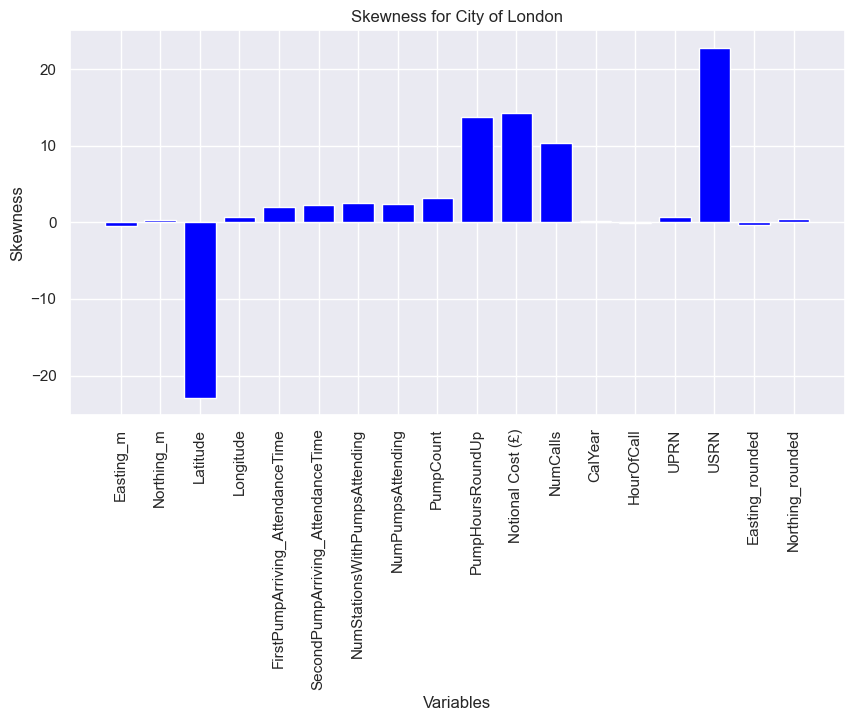

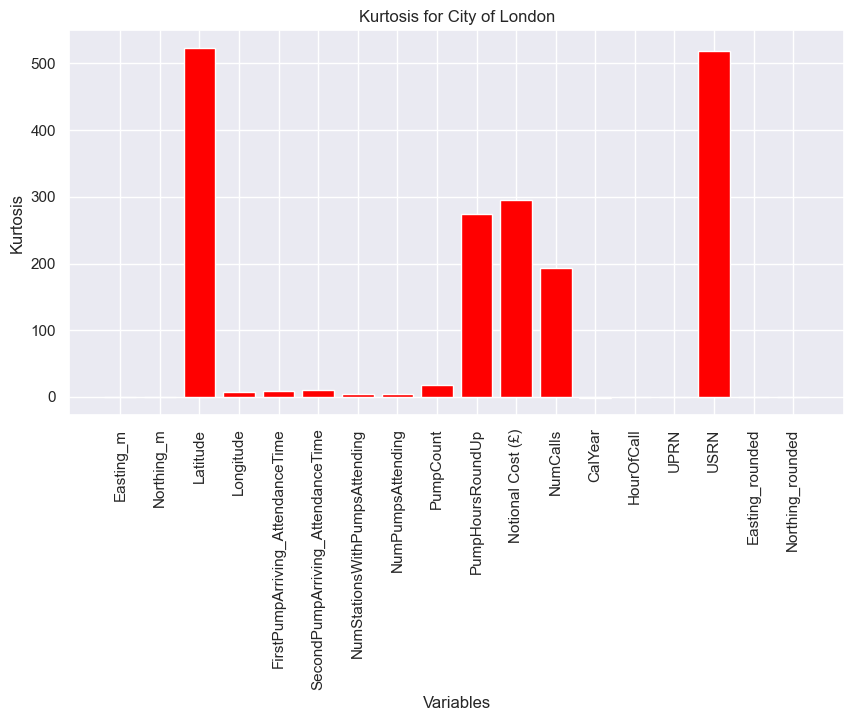

In [ ]:
skewness = CityOfLondon[numerical_columns].skew()
kurtosis = CityOfLondon[numerical_columns].kurtosis()

print("Skewness for City of London:\n", skewness)
print("\nKurtosis for City of London:\n", kurtosis)

# Plot skewness
plt.figure(figsize=(10, 5))
plt.bar(skewness.index, skewness.values, color='blue')
plt.title('Skewness for City of London')
plt.xlabel('Variables')
plt.ylabel('Skewness')
plt.xticks(rotation=90)
plt.show()

# Plot kurtosis
plt.figure(figsize=(10, 5))
plt.bar(kurtosis.index, kurtosis.values, color='red')
plt.title('Kurtosis for City of London')
plt.xlabel('Variables')
plt.ylabel('Kurtosis')
plt.xticks(rotation=90)
plt.show()


# Calculate the Value Range Mode in City OF London

Value Range:
 Easting_m                            2.786000e+03
Northing_m                           1.687000e+03
Latitude                             5.152249e+01
Longitude                            1.128845e-01
FirstPumpArriving_AttendanceTime     1.164000e+03
SecondPumpArriving_AttendanceTime    1.113000e+03
NumStationsWithPumpsAttending        5.000000e+00
NumPumpsAttending                    5.000000e+00
PumpCount                            1.800000e+01
PumpHoursRoundUp                     3.500000e+01
Notional Cost (£)                    1.277100e+04
NumCalls                             1.700000e+01
CalYear                              3.000000e+00
HourOfCall                           2.300000e+01
UPRN                                 2.000001e+11
USRN                                 1.460081e+07
Easting_rounded                      2.800000e+03
Northing_rounded                     1.700000e+03
dtype: float64

Mode:
 Easting_m                            5.316080e+05
Northing_m   

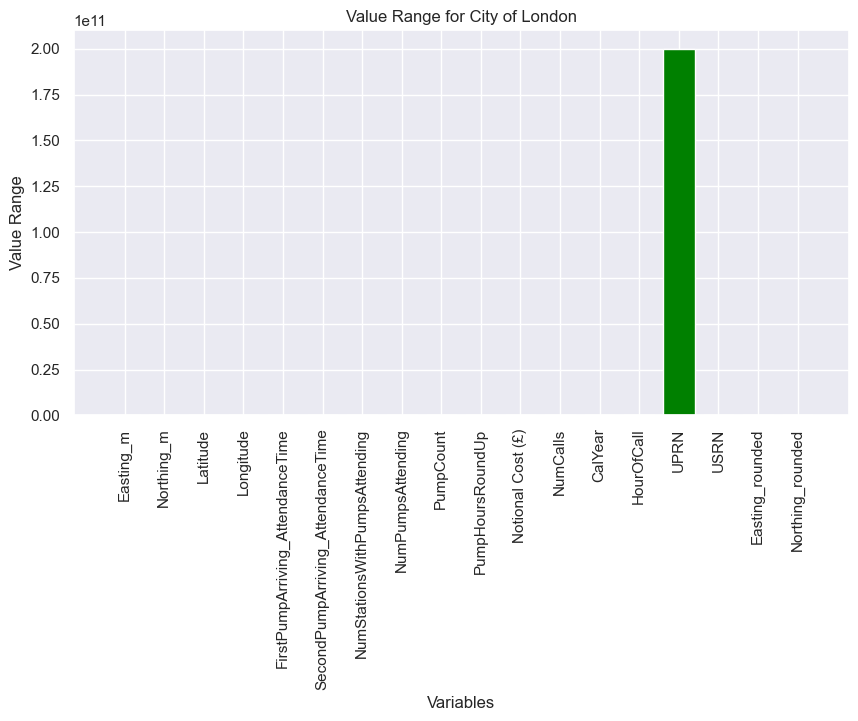

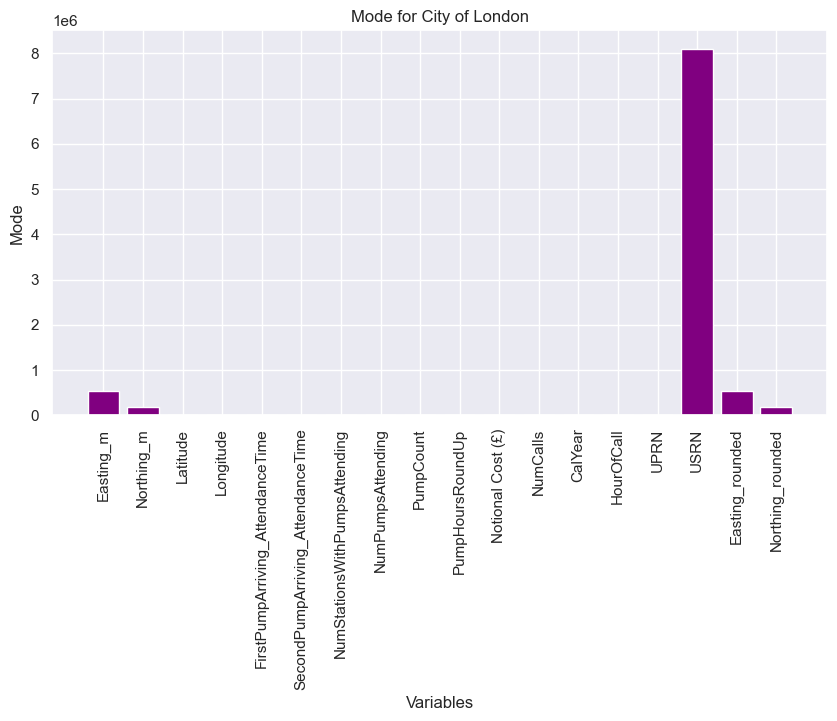

In [ ]:
CityOfLondon_numerical = CityOfLondon[numerical_columns]

# Calculate the value range for each column
value_range = CityOfLondon_numerical.max() - CityOfLondon_numerical.min()

# Calculate the mode for each column
mode = CityOfLondon_numerical.mode().iloc[0]

print("Value Range:\n", value_range)
print("\nMode:\n", mode)

# Plot value range
plt.figure(figsize=(10, 5))
plt.bar(value_range.index, value_range.values, color='green')
plt.title('Value Range for City of London')
plt.xlabel('Variables')
plt.ylabel('Value Range')
plt.xticks(rotation=90)
plt.show()

# Plot mode
plt.figure(figsize=(10, 5))
plt.bar(mode.index, mode.values, color='purple')
plt.title('Mode for City of London')
plt.xlabel('Variables')
plt.ylabel('Mode')
plt.xticks(rotation=90)
plt.show()


# Number of Instances in City Of London

In [ ]:
num_instances = len(CityOfLondon)
print(num_instances)


4110


# Initial Exploration

# Making Data Easy to read


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

# DISTRIBUTION OF KEY ATTRIBUTES

# Create histograms for all numerical variables

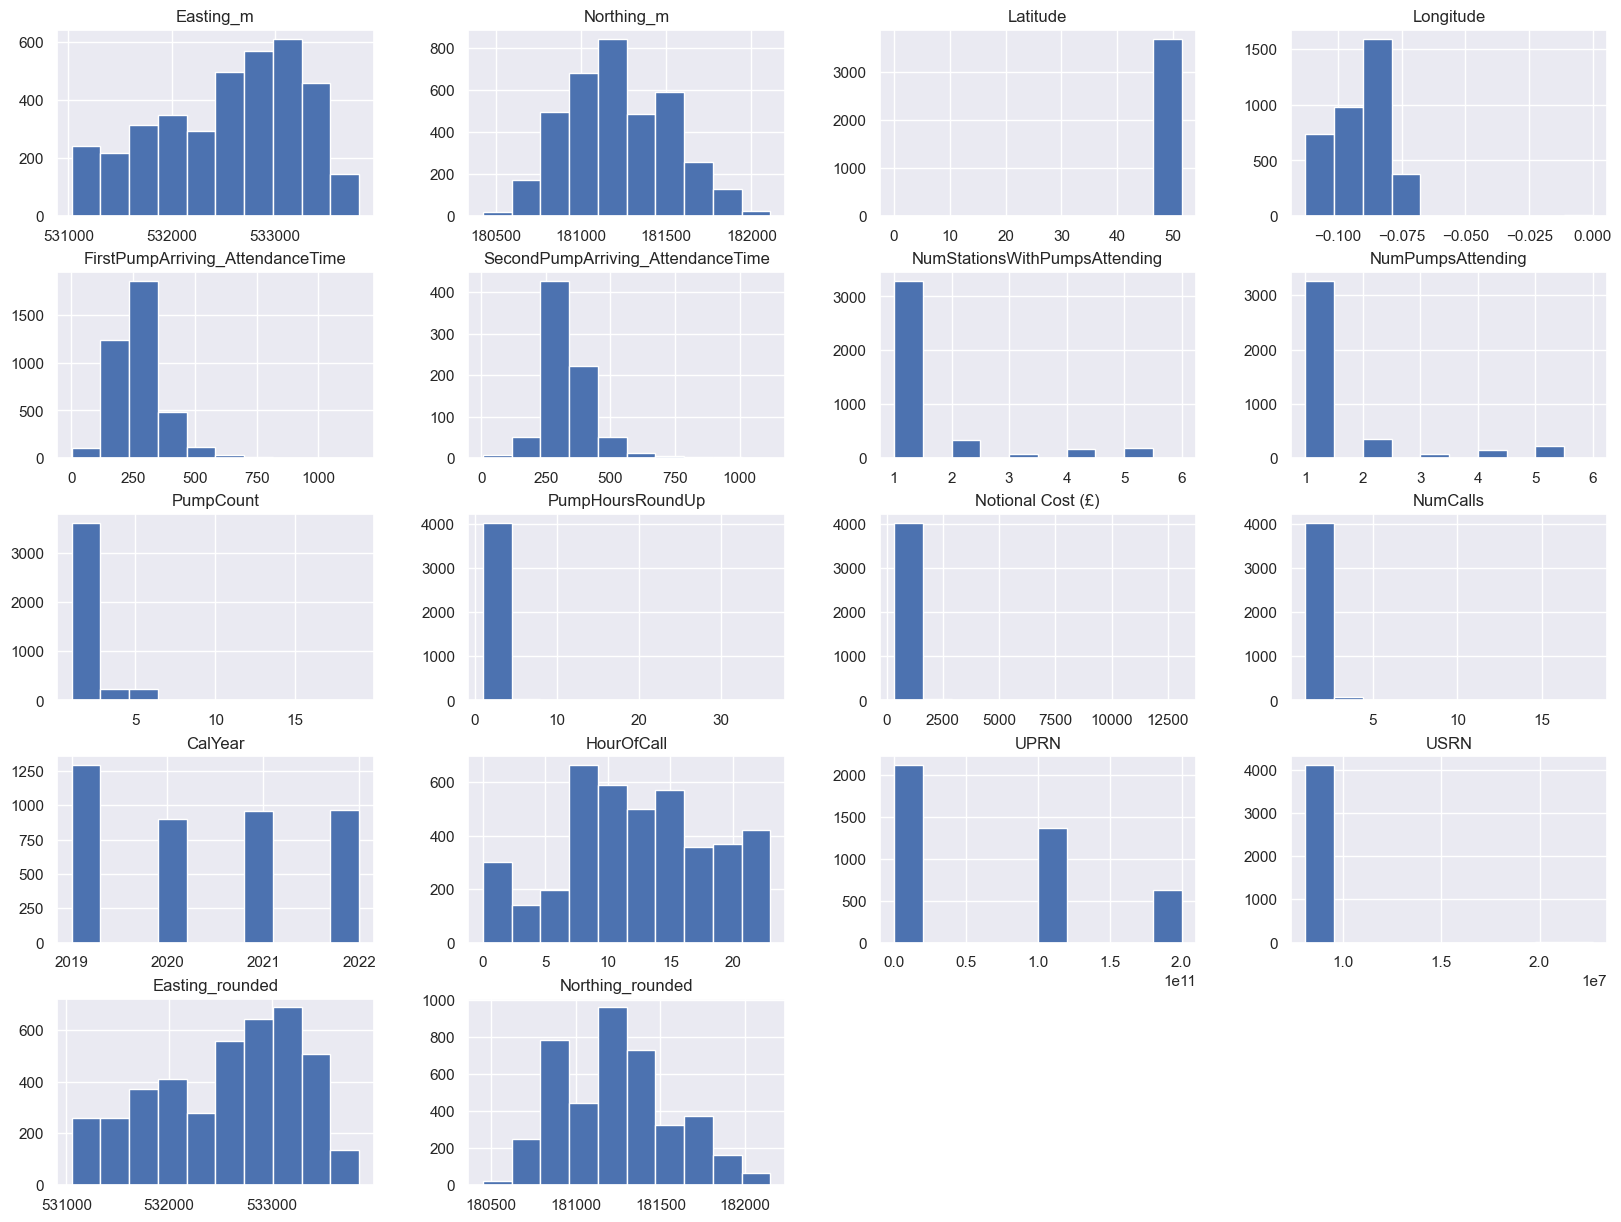

In [ ]:
CityOfLondon[numerical_columns].hist(figsize=(20, 15))
plt.show()


# Checking for patterns and Trends in the Data


# Showing the distribution of the hour of call for different property categories in the City Of London borough.

Hourly Distribution of Fire Incidents by Property Category in City of London:
PropertyCategory  Boat  Dwelling  Non Residential  Other Residential  Outdoor  \
HourOfCall                                                                      
0                  NaN      14.0             88.0                5.0      4.0   
1                  NaN      10.0             76.0                8.0      3.0   
2                  NaN      12.0             56.0                3.0      2.0   
3                  NaN       8.0             57.0                6.0      2.0   
4                  NaN       7.0             49.0                4.0      NaN   
5                  NaN      12.0             80.0                3.0      1.0   
6                  NaN      13.0             76.0                3.0      5.0   
7                  NaN      11.0            131.0                5.0      2.0   
8                  NaN      22.0            204.0                3.0      2.0   
9                  NaN      12.

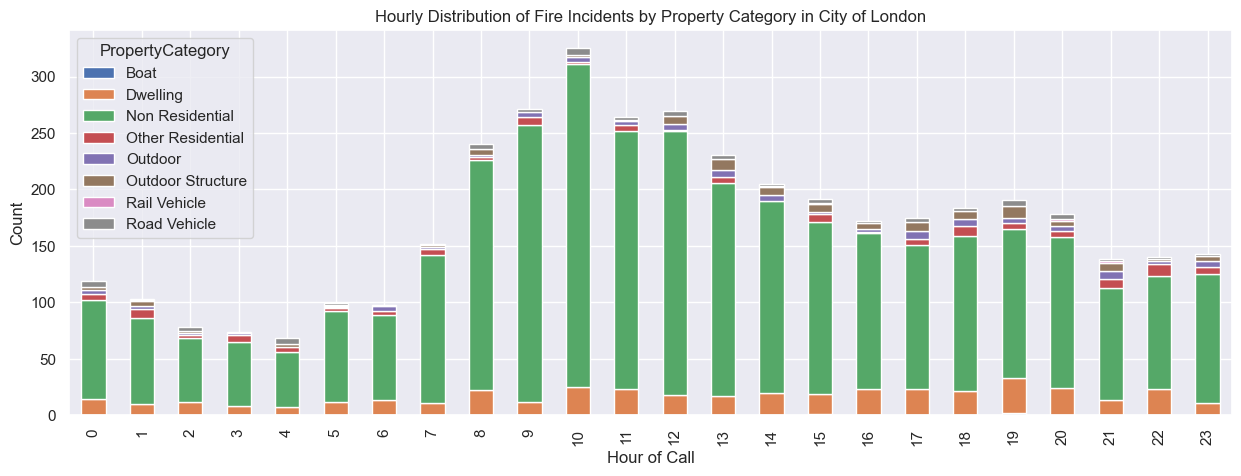

In [ ]:
# Calculate the count of incidents by hour and property category
hourly_counts = CityOfLondon.groupby(['HourOfCall', 'PropertyCategory'])['IncidentNumber'].count().reset_index()

# Pivot the data to create a stacked bar chart
hourly_counts = hourly_counts.pivot(index='HourOfCall', columns='PropertyCategory', values='IncidentNumber')

# Print the counts
print("Hourly Distribution of Fire Incidents by Property Category in City of London:")
print(hourly_counts)

# Create the stacked bar chart
hourly_counts.plot(kind='bar', stacked=True, figsize=(15,5))
plt.title('Hourly Distribution of Fire Incidents by Property Category in City of London')
plt.xlabel('Hour of Call')
plt.ylabel('Count')
plt.show()


# Distribution of Fire Incidents by Northing_m in City Of London

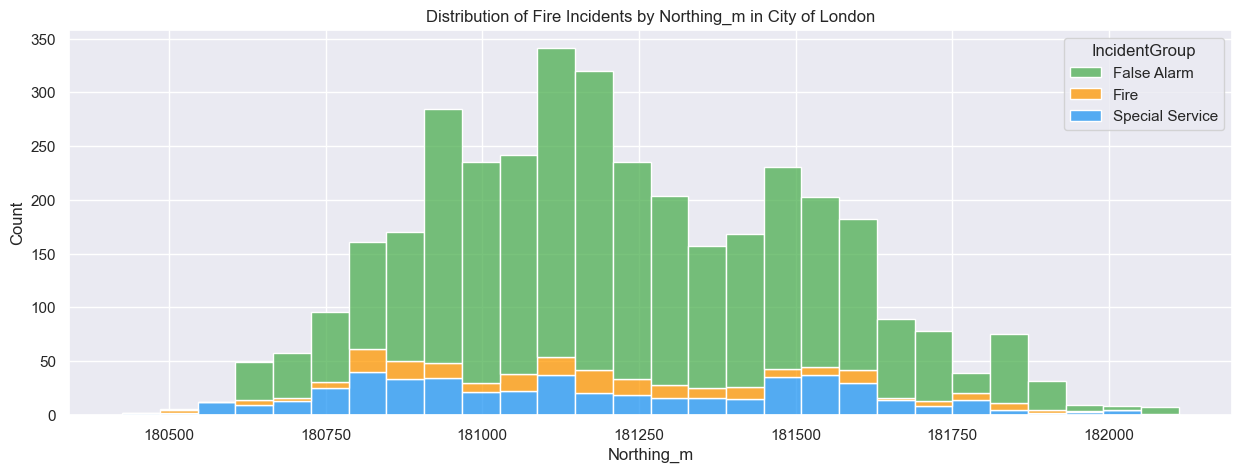

Distribution of Fire Incidents by Northing_m in City of London:
Northing_m  IncidentGroup  
180425.0    Special Service    1
180469.0    Special Service    1
180500.0    False Alarm        1
180527.0    Special Service    1
180537.0    Special Service    1
                              ..
182062.0    False Alarm        1
182080.0    False Alarm        2
182081.0    False Alarm        2
182092.0    False Alarm        1
182112.0    Fire               1
Length: 1481, dtype: int64


In [ ]:
# Define a custom color palette
custom_palette = ['#4CAF50', '#FF9800', '#2196F3', '#E91E63', '#9C27B0']

# Set the color palette
sns.set_palette(custom_palette)

# Create the histogram
plt.figure(figsize=(15,5))
plt.title('Distribution of Fire Incidents by Northing_m in City of London')
sns.histplot(data=CityOfLondon, x='Northing_m', hue='IncidentGroup', multiple='stack')
plt.show()

# Print the values
print("Distribution of Fire Incidents by Northing_m in City of London:")
print(CityOfLondon.groupby(['Northing_m', 'IncidentGroup']).size())


# Distribution of Easting_m by Incident Group in City of London

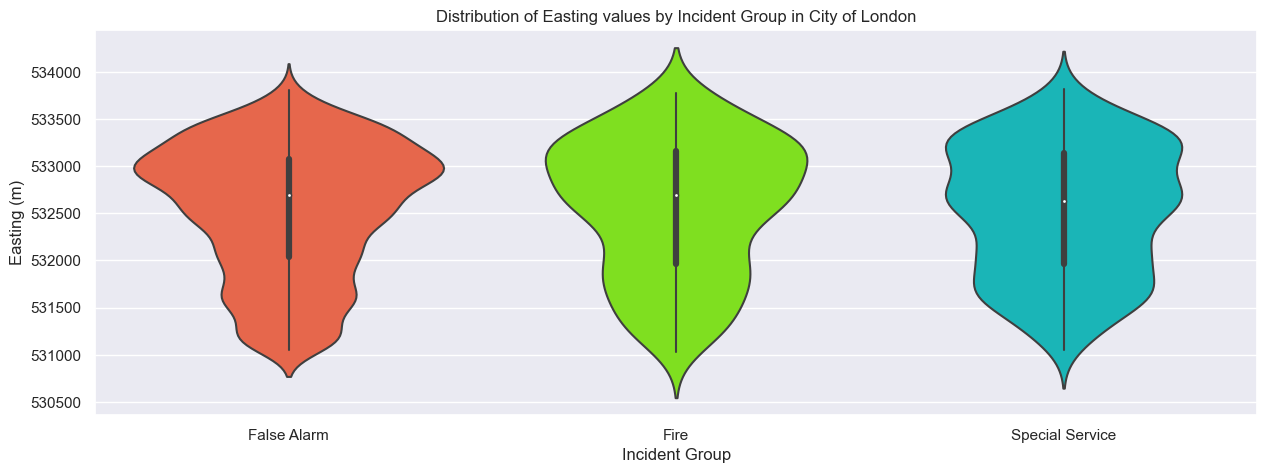

Summary statistics of Easting values by Incident Group in City of London:
                  count           mean         std       min       25%  \
IncidentGroup                                                            
False Alarm      2974.0  532544.996301  702.698769  531055.0  532033.0   
Fire              231.0  532569.086580  720.716595  531031.0  531958.5   
Special Service   489.0  532527.118609  692.527376  531048.0  531959.0   

                      50%        75%       max  
IncidentGroup                                   
False Alarm      532692.5  533080.75  533803.0  
Fire             532694.0  533161.50  533771.0  
Special Service  532628.0  533138.00  533817.0  


In [ ]:
# Define a custom color palette
custom_palette = ['#FF5733', '#7FFF00', '#00CED1', '#FFC300', '#C70039']

# Set the color palette
sns.set_palette(custom_palette)

# Create the violin plot
plt.figure(figsize=(15,5))
sns.violinplot(data=CityOfLondon, x='IncidentGroup', y='Easting_m')
plt.title('Distribution of Easting values by Incident Group in City of London')
plt.xlabel('Incident Group')
plt.ylabel('Easting (m)')
plt.show()

# Print the summary statistics
print("Summary statistics of Easting values by Incident Group in City of London:")
print(CityOfLondon.groupby('IncidentGroup')['Easting_m'].describe())


# Location of Fire Incidents in City of London

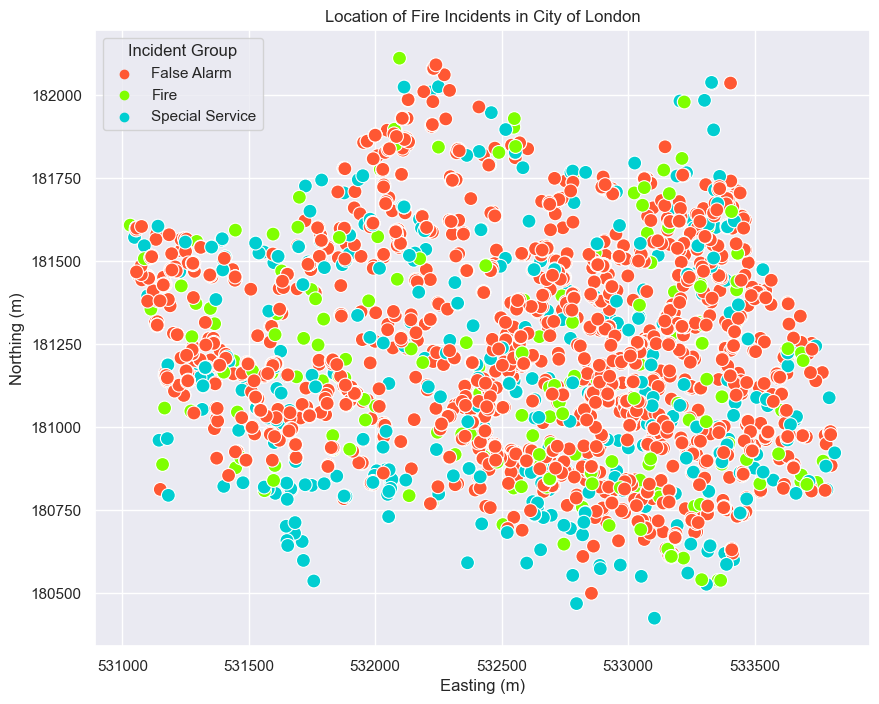

Location of Fire Incidents in City of London:
      Easting_m  Northing_m IncidentGroup
0      531793.0    181139.0   False Alarm
1      531545.0    181052.0   False Alarm
2      531442.0    181200.0          Fire
3      533216.0    181224.0   False Alarm
4      531830.0    181195.0   False Alarm
...         ...         ...           ...
4105   533024.0    181087.0          Fire
4106   533084.0    180829.0   False Alarm
4107   532482.0    180895.0          Fire
4108   532476.0    180901.0   False Alarm
4109   531864.0    181427.0   False Alarm

[4110 rows x 3 columns]


In [ ]:
# Define a custom color palette
custom_palette = ['#FF5733', '#7FFF00', '#00CED1', '#FFC300', '#C70039']

# Set the color palette
sns.set_palette(custom_palette)

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=CityOfLondon, x='Easting_m', y='Northing_m', hue='IncidentGroup', s=100)
plt.title('Location of Fire Incidents in City of London')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend(title='Incident Group')

plt.show()

# Print the values
print("Location of Fire Incidents in City of London:")
print(CityOfLondon[['Easting_m', 'Northing_m', 'IncidentGroup']])


# Response Time Distribution by Incident Group in City of London

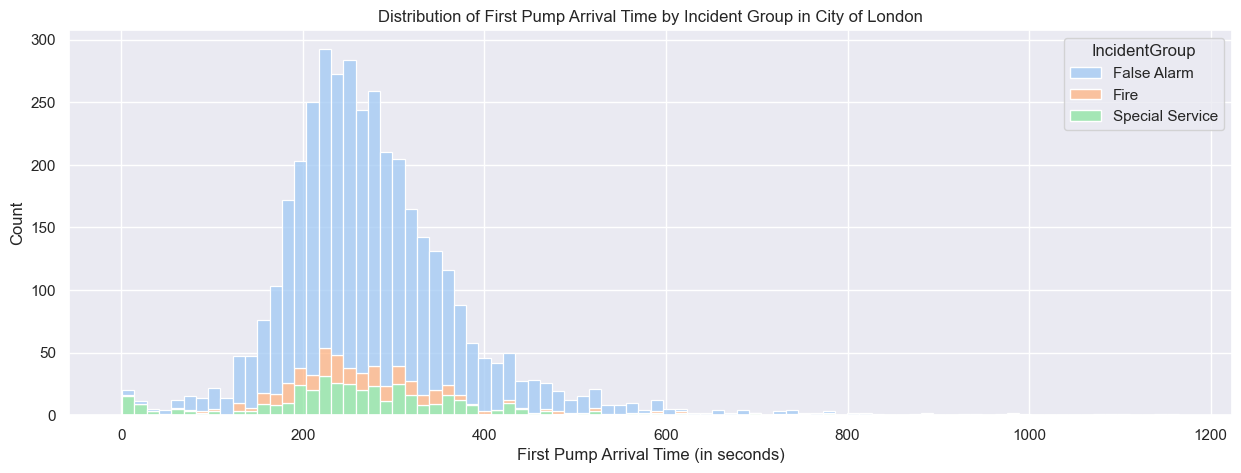

Distribution of First Pump Arrival Time by Incident Group in City of London:
FirstPumpArriving_AttendanceTime  IncidentGroup  
1.0                               False Alarm        1
2.0                               Fire               1
                                  Special Service    1
3.0                               False Alarm        2
                                  Special Service    4
                                                    ..
1075.0                            False Alarm        1
1084.0                            False Alarm        1
1102.0                            False Alarm        1
1143.0                            False Alarm        1
1165.0                            False Alarm        1
Length: 906, dtype: int64


In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(data=CityOfLondon, x='FirstPumpArriving_AttendanceTime', hue='IncidentGroup', multiple='stack', palette='pastel')
plt.title('Distribution of First Pump Arrival Time by Incident Group in City of London')
plt.xlabel('First Pump Arrival Time (in seconds)')
plt.ylabel('Count')
plt.show()

# Print the values
print("Distribution of First Pump Arrival Time by Incident Group in City of London:")
print(CityOfLondon.groupby(['FirstPumpArriving_AttendanceTime', 'IncidentGroup']).size())


# CUMULATIVE DISTRIBUTION

# the distribution of HourOfCall across different IncidentGroup categories in City of London.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


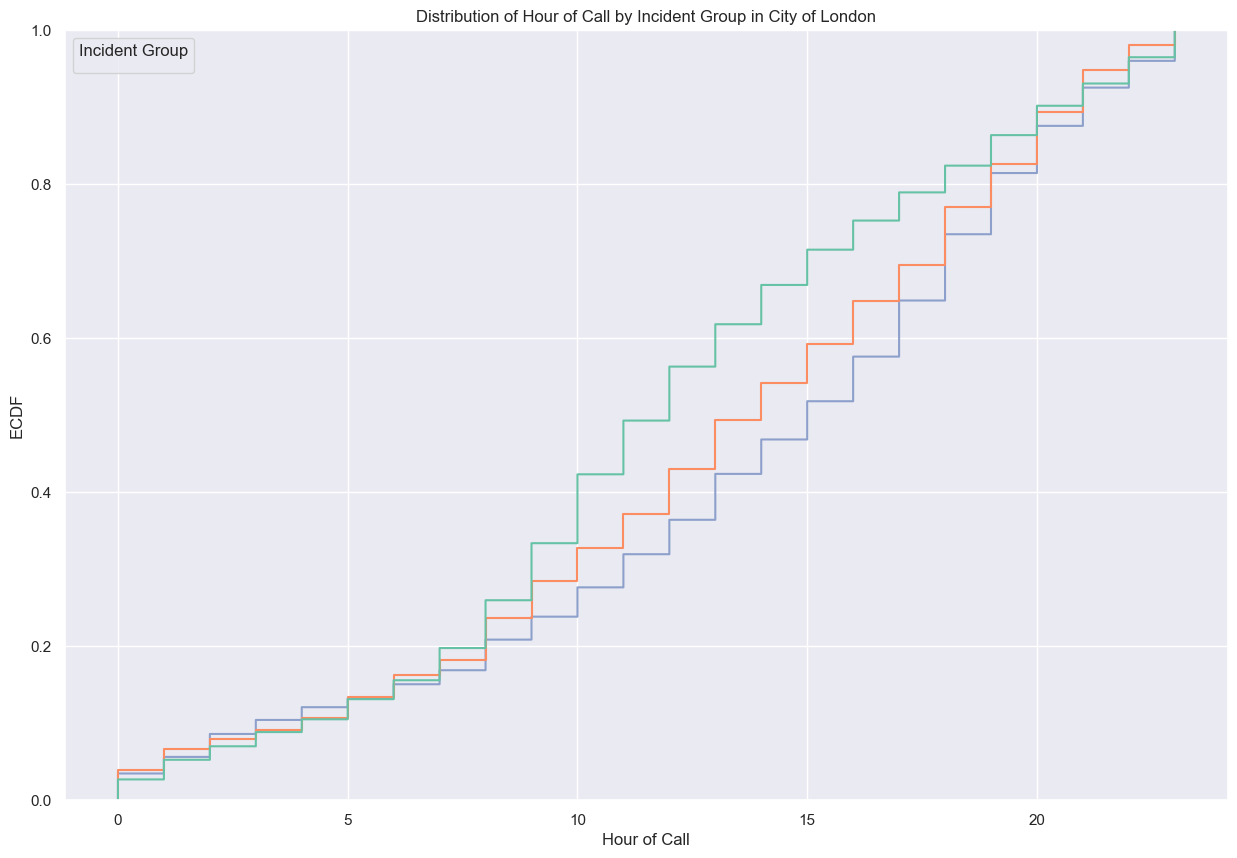

Distribution of Hour of Call by Incident Group in City of London:
HourOfCall  IncidentGroup  
0           False Alarm         88
            Fire                10
            Special Service     21
1           False Alarm         83
            Fire                 7
            Special Service     13
2           False Alarm         57
            Fire                 3
            Special Service     18
3           False Alarm         60
            Fire                 3
            Special Service     11
4           False Alarm         54
            Fire                 4
            Special Service     10
5           False Alarm         85
            Fire                 7
            Special Service      7
6           False Alarm         80
            Fire                 7
            Special Service     11
7           False Alarm        136
            Fire                 5
            Special Service     11
8           False Alarm        202
            Fire               

In [ ]:
plt.figure(figsize=(15, 10))
sns.ecdfplot(data=CityOfLondon, x='HourOfCall', hue='IncidentGroup', palette='Set2')
plt.xlabel('Hour of Call')
plt.ylabel('ECDF')
plt.title('Distribution of Hour of Call by Incident Group in City of London')
plt.legend(title='Incident Group')

plt.show()

# Print the values
print("Distribution of Hour of Call by Incident Group in City of London:")
print(CityOfLondon.groupby(['HourOfCall', 'IncidentGroup']).size())


# the distribution of the Hour of Call variable for each Property Category in the City of London.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


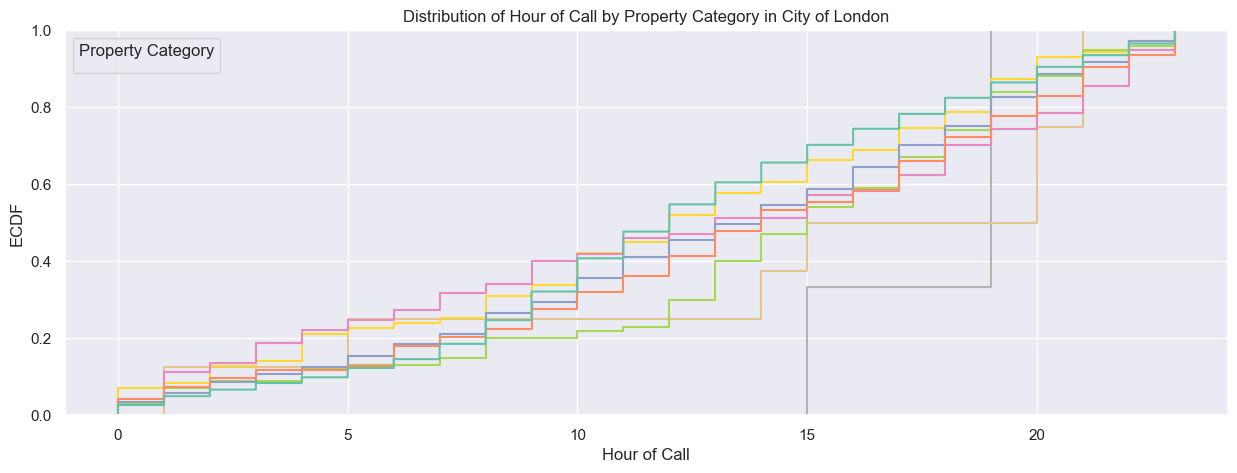

Distribution of Hour of Call by Property Category in City of London:
HourOfCall  PropertyCategory 
0           Dwelling              14
            Non Residential       88
            Other Residential      5
            Outdoor                4
            Outdoor Structure      3
                                ... 
23          Non Residential      114
            Other Residential      6
            Outdoor                6
            Outdoor Structure      4
            Road Vehicle           2
Length: 147, dtype: int64


In [ ]:
plt.figure(figsize=(15, 5))
sns.ecdfplot(data=CityOfLondon, x='HourOfCall', hue='PropertyCategory', palette='Set2')
plt.xlabel('Hour of Call')
plt.ylabel('ECDF')
plt.title('Distribution of Hour of Call by Property Category in City of London')
plt.legend(title='Property Category')

plt.show()

# Print the values
print("Distribution of Hour of Call by Property Category in City of London:")
print(CityOfLondon.groupby(['HourOfCall', 'PropertyCategory']).size())


# BIVERATE DISTRIBUTION

# Distribution of Easting_m and Northing_m by Incident Group in City of London

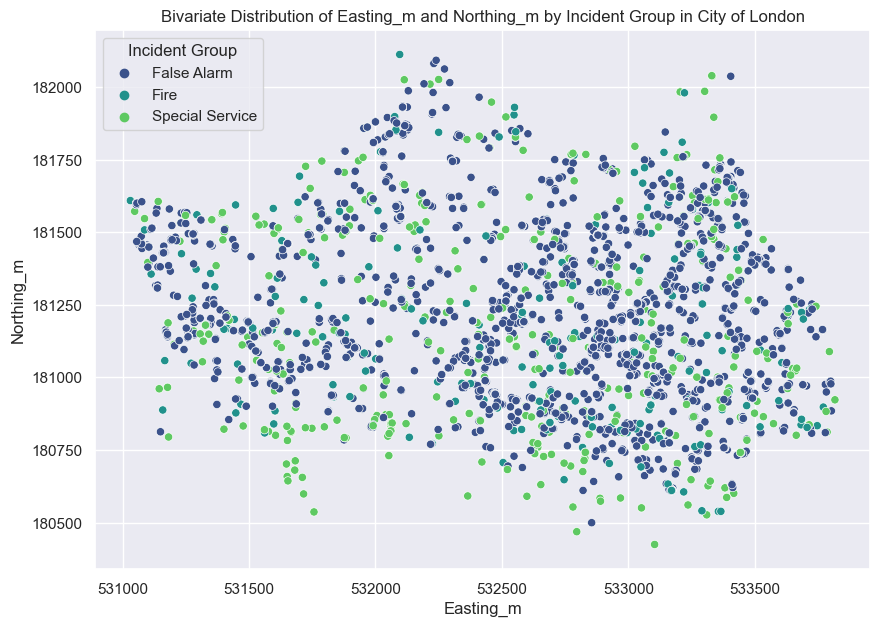

Bivariate Distribution of Easting_m and Northing_m by Incident Group in City of London:
      Easting_m  Northing_m IncidentGroup
0      531793.0    181139.0   False Alarm
1      531545.0    181052.0   False Alarm
2      531442.0    181200.0          Fire
3      533216.0    181224.0   False Alarm
4      531830.0    181195.0   False Alarm
...         ...         ...           ...
4105   533024.0    181087.0          Fire
4106   533084.0    180829.0   False Alarm
4107   532482.0    180895.0          Fire
4108   532476.0    180901.0   False Alarm
4109   531864.0    181427.0   False Alarm

[4110 rows x 3 columns]


In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=CityOfLondon, x='Easting_m', y='Northing_m', hue='IncidentGroup', palette='viridis')
plt.title('Bivariate Distribution of Easting_m and Northing_m by Incident Group in City of London')
plt.xlabel('Easting_m')
plt.ylabel('Northing_m')
plt.legend(title='Incident Group')

plt.show()

# Print the values
print("Bivariate Distribution of Easting_m and Northing_m by Incident Group in City of London:")
print(CityOfLondon[['Easting_m', 'Northing_m', 'IncidentGroup']])


# Spatial Distribution of Incidents by Borough

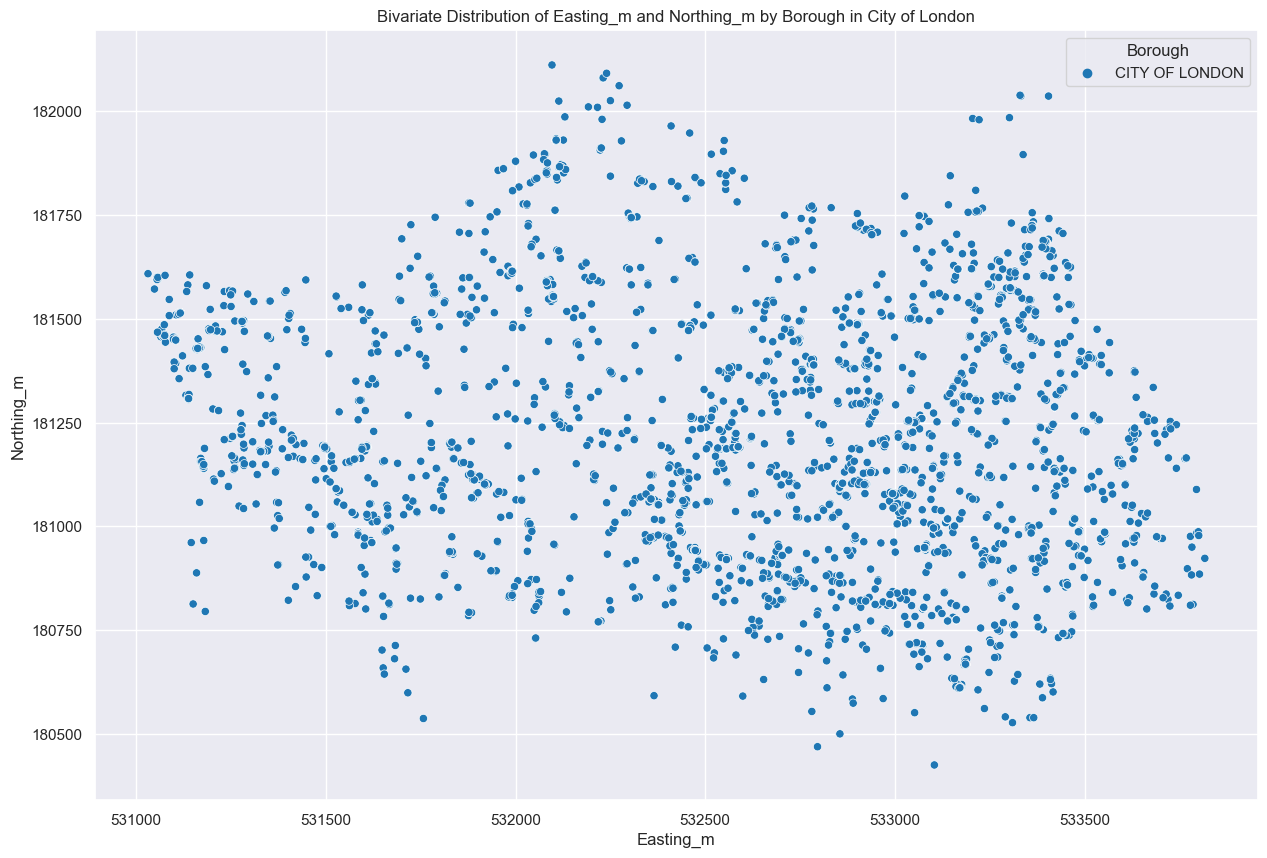

Bivariate Distribution of Easting_m and Northing_m by Borough in City of London:
      Easting_m  Northing_m IncGeo_BoroughName
0      531793.0    181139.0     CITY OF LONDON
1      531545.0    181052.0     CITY OF LONDON
2      531442.0    181200.0     CITY OF LONDON
3      533216.0    181224.0     CITY OF LONDON
4      531830.0    181195.0     CITY OF LONDON
...         ...         ...                ...
4105   533024.0    181087.0     CITY OF LONDON
4106   533084.0    180829.0     CITY OF LONDON
4107   532482.0    180895.0     CITY OF LONDON
4108   532476.0    180901.0     CITY OF LONDON
4109   531864.0    181427.0     CITY OF LONDON

[4110 rows x 3 columns]


In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=CityOfLondon, x='Easting_m', y='Northing_m', hue='IncGeo_BoroughName', palette='tab10')
plt.title('Bivariate Distribution of Easting_m and Northing_m by Borough in City of London')
plt.xlabel('Easting_m')
plt.ylabel('Northing_m')
plt.legend(title='Borough')

plt.show()

# Print the values
print("Bivariate Distribution of Easting_m and Northing_m by Borough in City of London:")
print(CityOfLondon[['Easting_m', 'Northing_m', 'IncGeo_BoroughName']])


# Visualizing City of London Borough Incidents by Location and Type

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

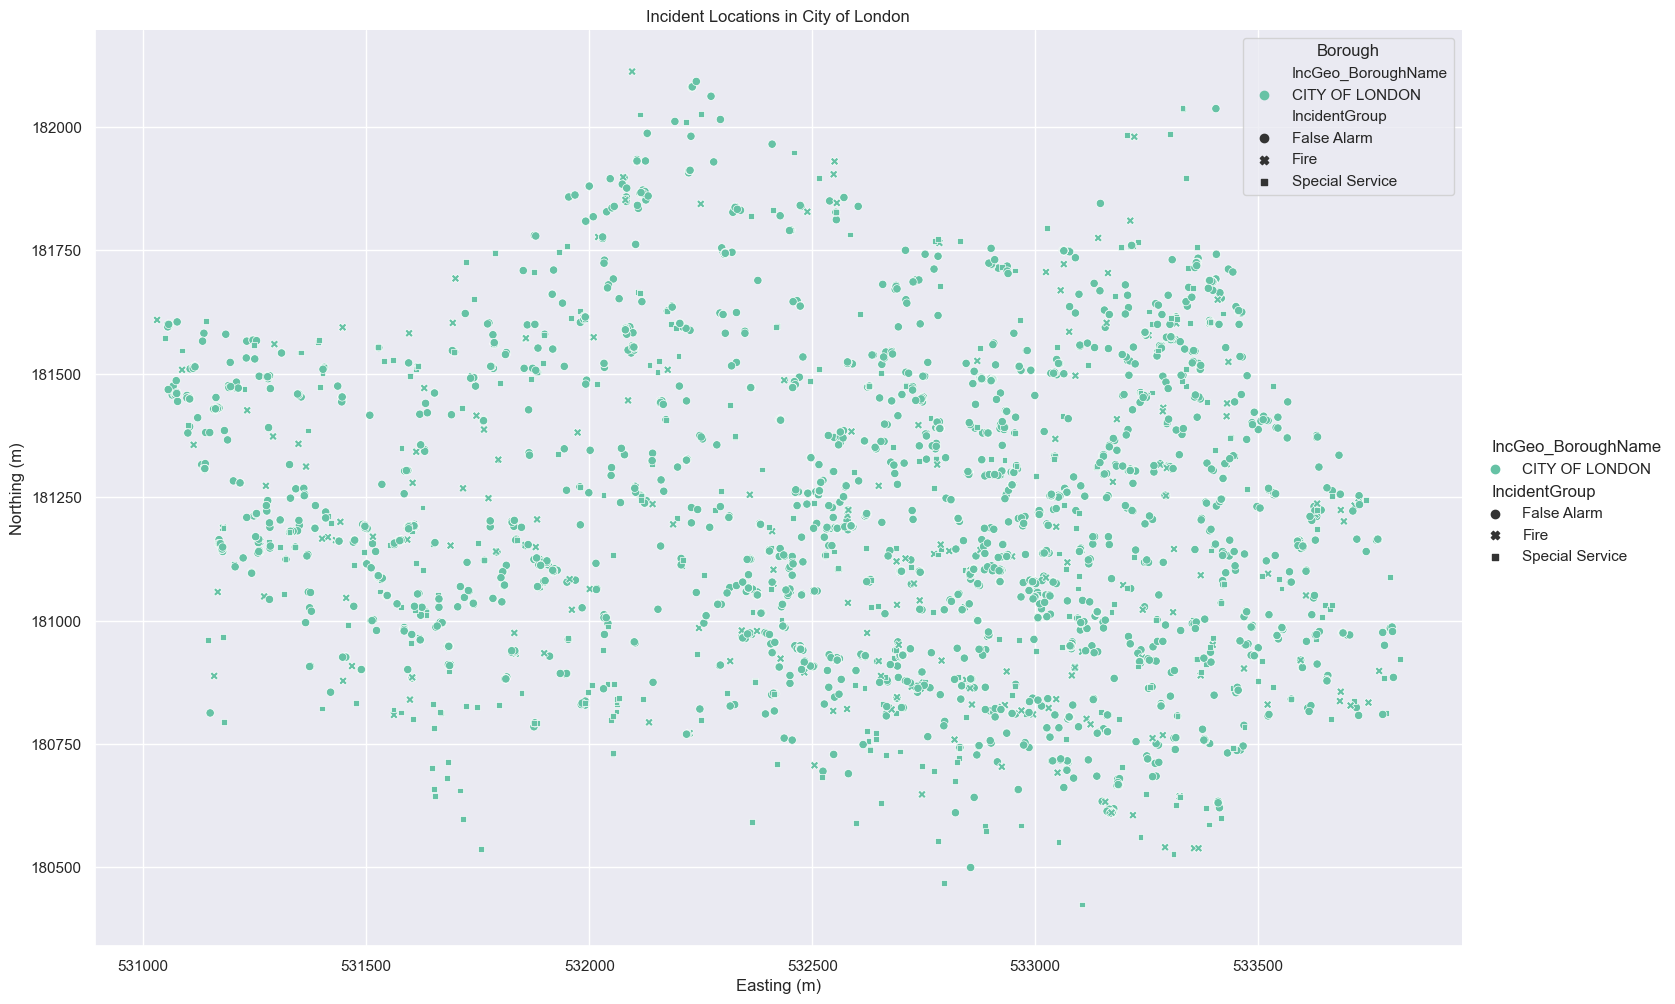

Incident Locations in City of London:
      Easting_m  Northing_m IncidentGroup IncGeo_BoroughName
0      531793.0    181139.0   False Alarm     CITY OF LONDON
1      531545.0    181052.0   False Alarm     CITY OF LONDON
2      531442.0    181200.0          Fire     CITY OF LONDON
3      533216.0    181224.0   False Alarm     CITY OF LONDON
4      531830.0    181195.0   False Alarm     CITY OF LONDON
...         ...         ...           ...                ...
4105   533024.0    181087.0          Fire     CITY OF LONDON
4106   533084.0    180829.0   False Alarm     CITY OF LONDON
4107   532482.0    180895.0          Fire     CITY OF LONDON
4108   532476.0    180901.0   False Alarm     CITY OF LONDON
4109   531864.0    181427.0   False Alarm     CITY OF LONDON

[4110 rows x 4 columns]


In [ ]:
plt.figure(figsize=(15, 10))
sns.relplot(data=CityOfLondon, x='Easting_m', y='Northing_m', style='IncidentGroup', hue='IncGeo_BoroughName', height=10, aspect=1.5, palette='Set2')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Incident Locations in City of London')
plt.legend(title='Borough')
plt.show()

# Print the values
print("Incident Locations in City of London:")
print(CityOfLondon[['Easting_m', 'Northing_m', 'IncidentGroup', 'IncGeo_BoroughName']])


# Visualizing Notional Cost in City Of London borough using a Scatter Plot



C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

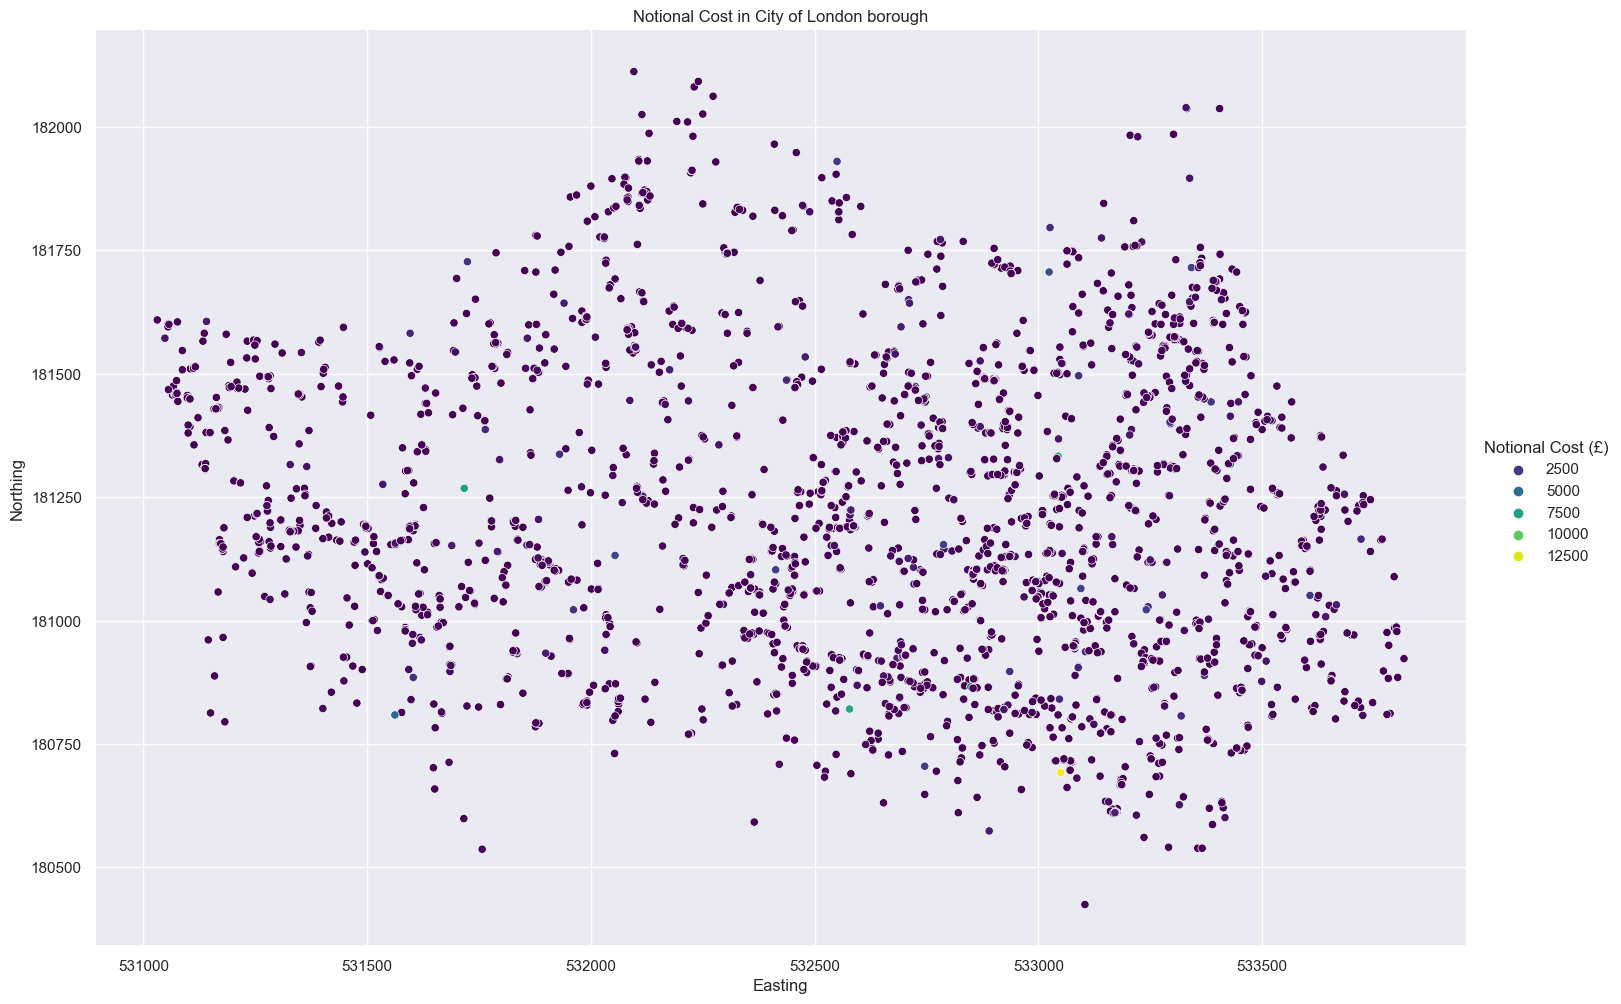

Notional Cost in City of London borough:
      Easting_m  Northing_m  Notional Cost (£)
0      531793.0    181139.0              333.0
1      531545.0    181052.0              333.0
2      531442.0    181200.0              333.0
3      533216.0    181224.0              666.0
4      531830.0    181195.0              333.0
...         ...         ...                ...
4105   533024.0    181087.0              364.0
4106   533084.0    180829.0              364.0
4107   532482.0    180895.0              364.0
4108   532476.0    180901.0              364.0
4109   531864.0    181427.0              364.0

[4110 rows x 3 columns]


In [ ]:
plt.figure(figsize=(15,10))
sns.relplot(data=CityOfLondon, x='Easting_m', y='Northing_m', hue='Notional Cost (£)', height=10, aspect=1.5, vmin=0, vmax=1000000, palette='viridis')
plt.title('Notional Cost in City of London borough')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

# Print the values
print("Notional Cost in City of London borough:")
print(CityOfLondon[['Easting_m', 'Northing_m', 'Notional Cost (£)']])


# Exploring the Relationship between Numeric and Categorical Variables using a Relational Plot

# Visualizing Hourly Call Volume for Different Incident Groups in City of London

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


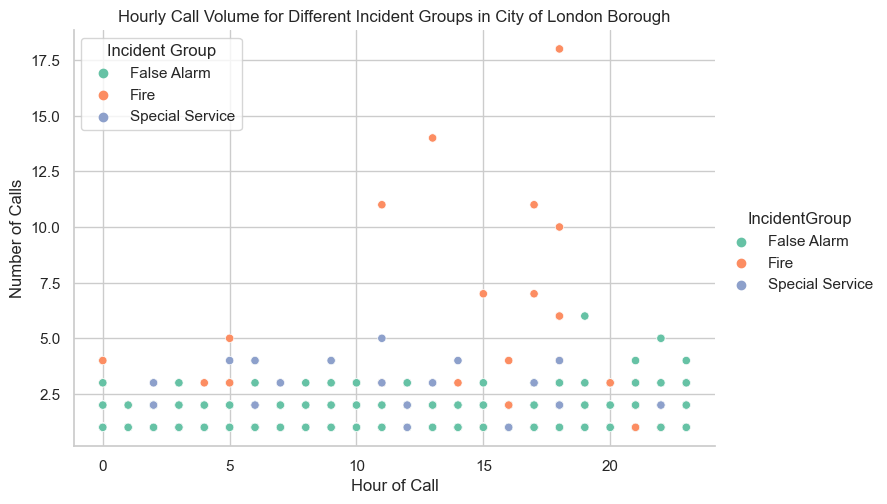

Hourly Call Volume for Different Incident Groups in City of London Borough:
      HourOfCall  NumCalls IncidentGroup
0             10       1.0   False Alarm
1             17       1.0   False Alarm
2              2       1.0          Fire
3              2       1.0   False Alarm
4              8       1.0   False Alarm
...          ...       ...           ...
4105          21       1.0          Fire
4106           7       1.0   False Alarm
4107          15       1.0          Fire
4108          15       1.0   False Alarm
4109          10       1.0   False Alarm

[4110 rows x 3 columns]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and color palette
sns.set_style('whitegrid')
sns.set_palette('Set2')  # Change the palette to Set2 or any other desired palette

# Create plot
sns.relplot(data=CityOfLondon, x='HourOfCall', y='NumCalls', hue='IncidentGroup', height=5, aspect=1.5)

# Customize plot
plt.title('Hourly Call Volume for Different Incident Groups in City of London Borough')
plt.xlabel('Hour of Call')
plt.ylabel('Number of Calls')
plt.legend(title='Incident Group')

# Show plot
plt.show()

# Print the values
print("Hourly Call Volume for Different Incident Groups in City of London Borough:")
print(CityOfLondon[['HourOfCall', 'NumCalls', 'IncidentGroup']])


# Visualization of Relationship Between Pumping Hours and Notional Cost by Year

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

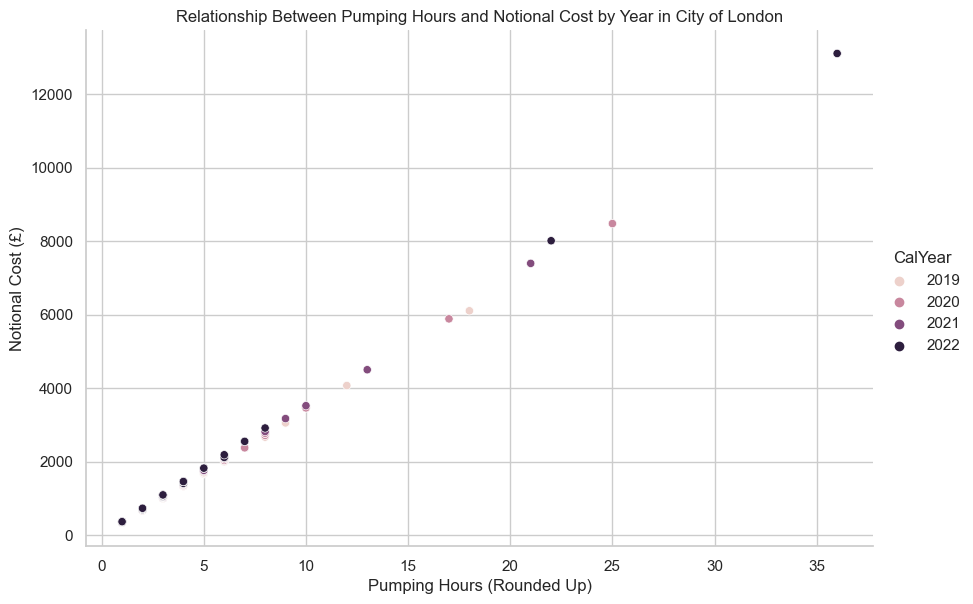

Relationship Between Pumping Hours and Notional Cost by Year in City of London:
      PumpHoursRoundUp  Notional Cost (£)  CalYear
0                  1.0              333.0     2019
1                  1.0              333.0     2019
2                  1.0              333.0     2019
3                  2.0              666.0     2019
4                  1.0              333.0     2019
...                ...                ...      ...
4105               1.0              364.0     2022
4106               1.0              364.0     2022
4107               1.0              364.0     2022
4108               1.0              364.0     2022
4109               1.0              364.0     2022

[4110 rows x 3 columns]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("tab10")

# Create the plot
plt.figure(figsize=(10,6))
sns.relplot(data=CityOfLondon, x='PumpHoursRoundUp', y='Notional Cost (£)', hue='CalYear', height=6, aspect=1.5)

# Customize plot
plt.title('Relationship Between Pumping Hours and Notional Cost by Year in City of London')
plt.xlabel('Pumping Hours (Rounded Up)')
plt.ylabel('Notional Cost (£)')

# Show plot
plt.show()

# Print the values
print("Relationship Between Pumping Hours and Notional Cost by Year in City of London:")
print(CityOfLondon[['PumpHoursRoundUp', 'Notional Cost (£)', 'CalYear']])


# Relationship between Notional Cost and Calendar Year in City Of London

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

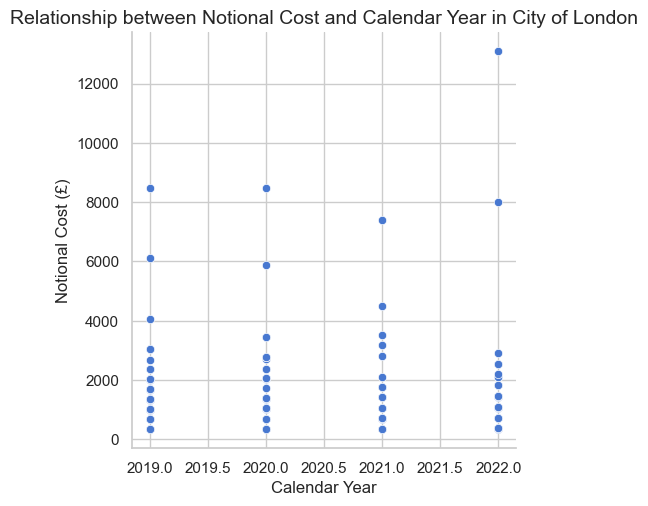

Relationship between Notional Cost and Calendar Year in City of London:
      CalYear  Notional Cost (£)
0        2019              333.0
1        2019              333.0
2        2019              333.0
3        2019              666.0
4        2019              333.0
...       ...                ...
4105     2022              364.0
4106     2022              364.0
4107     2022              364.0
4108     2022              364.0
4109     2022              364.0

[4110 rows x 2 columns]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("muted")

# Create the plot
plt.figure(figsize=(10, 6))
sns.relplot(data=CityOfLondon, x='CalYear', y='Notional Cost (£)')
plt.title("Relationship between Notional Cost and Calendar Year in City of London", fontsize=14)
plt.xlabel("Calendar Year", fontsize=12)
plt.ylabel("Notional Cost (£)", fontsize=12)

# Show plot
plt.show()

# Print the values
print("Relationship between Notional Cost and Calendar Year in City of London:")
print(CityOfLondon[['CalYear', 'Notional Cost (£)']])


# categorical attributes exploration

# Countplot of Incident Groups in City Of London

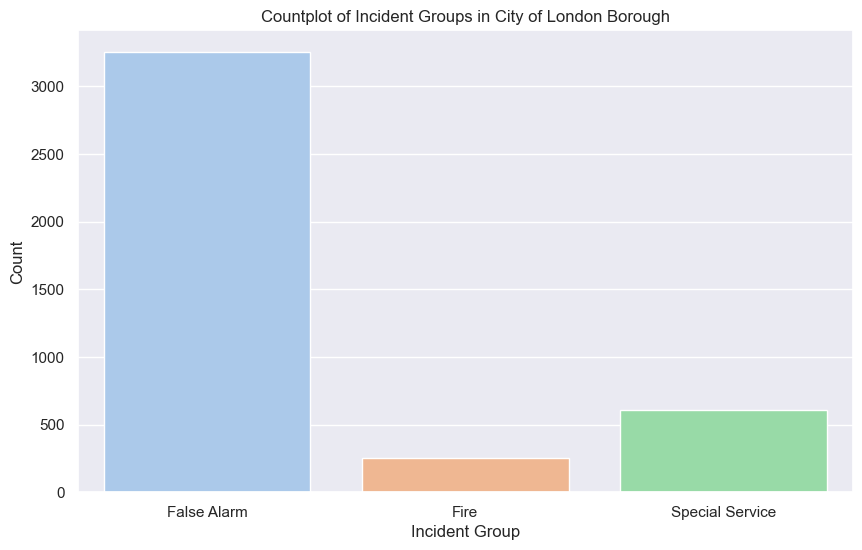

Countplot of Incident Groups in City of London Borough:
IncidentGroup
False Alarm        3253
Special Service     604
Fire                253
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("pastel")

# Create the countplot
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(data=CityOfLondon, x='IncidentGroup')
plt.title("Countplot of Incident Groups in City of London Borough")
plt.xlabel("Incident Group")
plt.ylabel("Count")

# Show plot
plt.show()

# Print the values
print("Countplot of Incident Groups in City of London Borough:")
print(CityOfLondon['IncidentGroup'].value_counts())


# Countplot of Categorical Variable

In [ ]:
# Deal with incorrect data types
CityOfLondon['DateOfCall'] = pd.to_datetime(CityOfLondon['DateOfCall'])


#  countplot of the DateOfCall column in the CityOfLondon

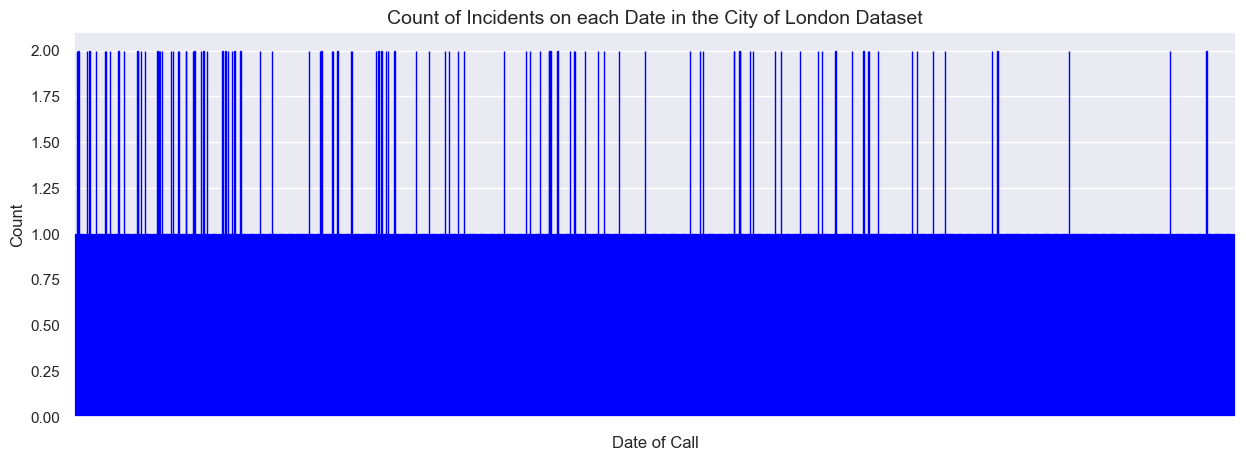

Count of Incidents on each Date in the City of London Dataset:
TimeOfCall
17:08:27    2
11:45:58    2
08:39:15    2
09:37:47    2
03:31:15    2
           ..
21:10:03    1
21:11:10    1
10:16:05    1
18:56:24    1
10:48:15    1
Name: count, Length: 4008, dtype: int64


In [ ]:
# Get the categorical columns in the dataset
categorical_columns = CityOfLondon.select_dtypes(include=['object']).columns

plt.figure(figsize=(15,5))
ax = sns.countplot(data=CityOfLondon, x=categorical_columns[1], palette='Set2', edgecolor='blue')
ax.set(xticklabels=[])
plt.xlabel("Date of Call", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Count of Incidents on each Date in the City of London Dataset", fontsize=14)
plt.show()

# Print the values
print("Count of Incidents on each Date in the City of London Dataset:")
print(CityOfLondon[categorical_columns[1]].value_counts())


# Count of Incidents by Stop Code Description in the city of london

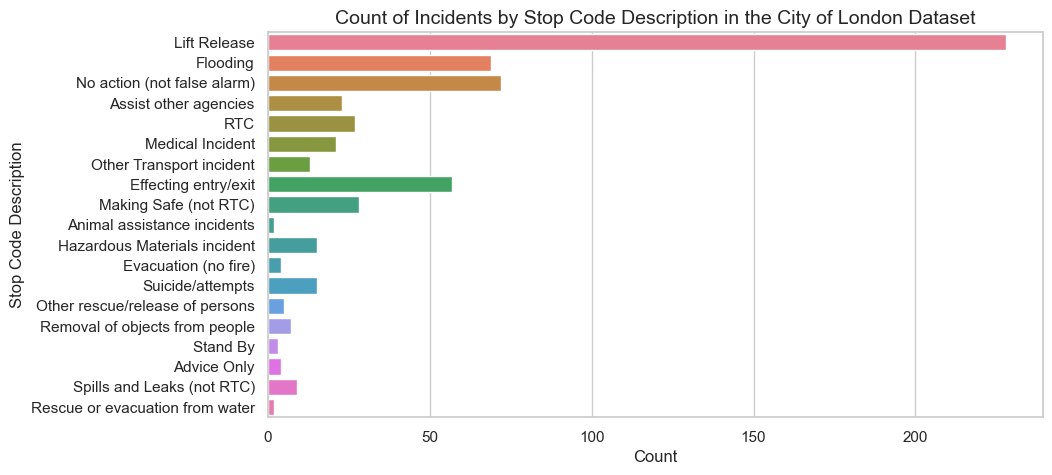

Count of Incidents by Stop Code Description in the City of London Dataset:
SpecialServiceType
Lift Release                       228
No action (not false alarm)         72
Flooding                            69
Effecting entry/exit                57
Making Safe (not RTC)               28
RTC                                 27
Assist other agencies               23
Medical Incident                    21
Hazardous Materials incident        15
Suicide/attempts                    15
Other Transport incident            13
Spills and Leaks (not RTC)           9
Removal of objects from people       7
Other rescue/release of persons      5
Evacuation (no fire)                 4
Advice Only                          4
Stand By                             3
Animal assistance incidents          2
Rescue or evacuation from water      2
Name: count, dtype: int64


In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

# Set the size of the plot
plt.figure(figsize=(10,5))

# Get the categorical columns in the dataset
categorical_columns = CityOfLondon.select_dtypes(include=['object']).columns

# Create the countplot of the Stop Code Description column
ax = sns.countplot(data=CityOfLondon, y=categorical_columns[4], palette='husl')

# Set the x and y labels and the title
plt.xlabel("Count", fontsize=12)
plt.ylabel("Stop Code Description", fontsize=12)
plt.title("Count of Incidents by Stop Code Description in the City of London Dataset", fontsize=14)

# Show the plot
plt.show()

# Print the values as 'dwell'
print("Count of Incidents by Stop Code Description in the City of London Dataset:")
print(CityOfLondon[categorical_columns[4]].value_counts())


# Count of Incidents by Special Service Type

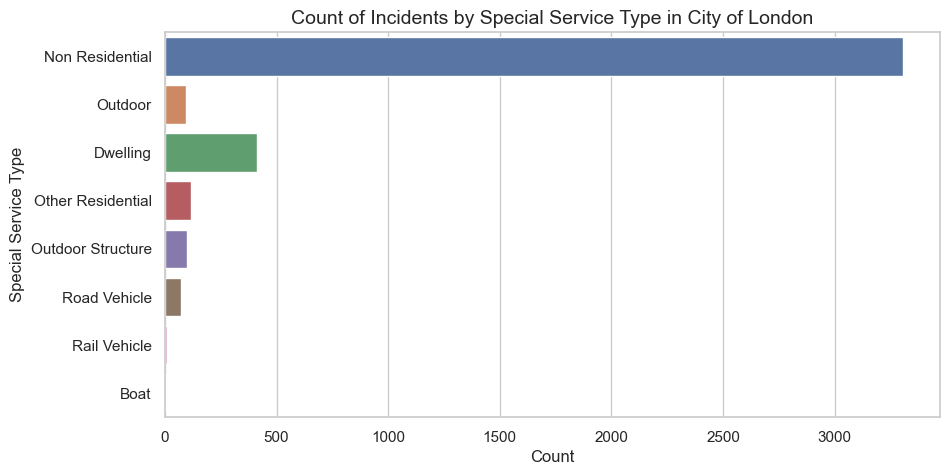

Count of Incidents by Special Service Type in City of London:
PropertyCategory
Non Residential      3306
Dwelling              411
Other Residential     117
Outdoor Structure     100
Outdoor                94
Road Vehicle           71
Rail Vehicle            8
Boat                    3
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
colors = sns.color_palette('deep')  # Change the color palette here

ax = sns.countplot(data=CityOfLondon, y=categorical_columns[5], palette=colors)
ax.set_ylabel('Special Service Type', fontsize=12)
ax.set_xlabel('Count', fontsize=12)
ax.set_title('Count of Incidents by Special Service Type in City of London', fontsize=14)

plt.show()

# Print the values
print("Count of Incidents by Special Service Type in City of London:")
print(CityOfLondon[categorical_columns[5]].value_counts())


# Distribution of Property Categories in the City of London

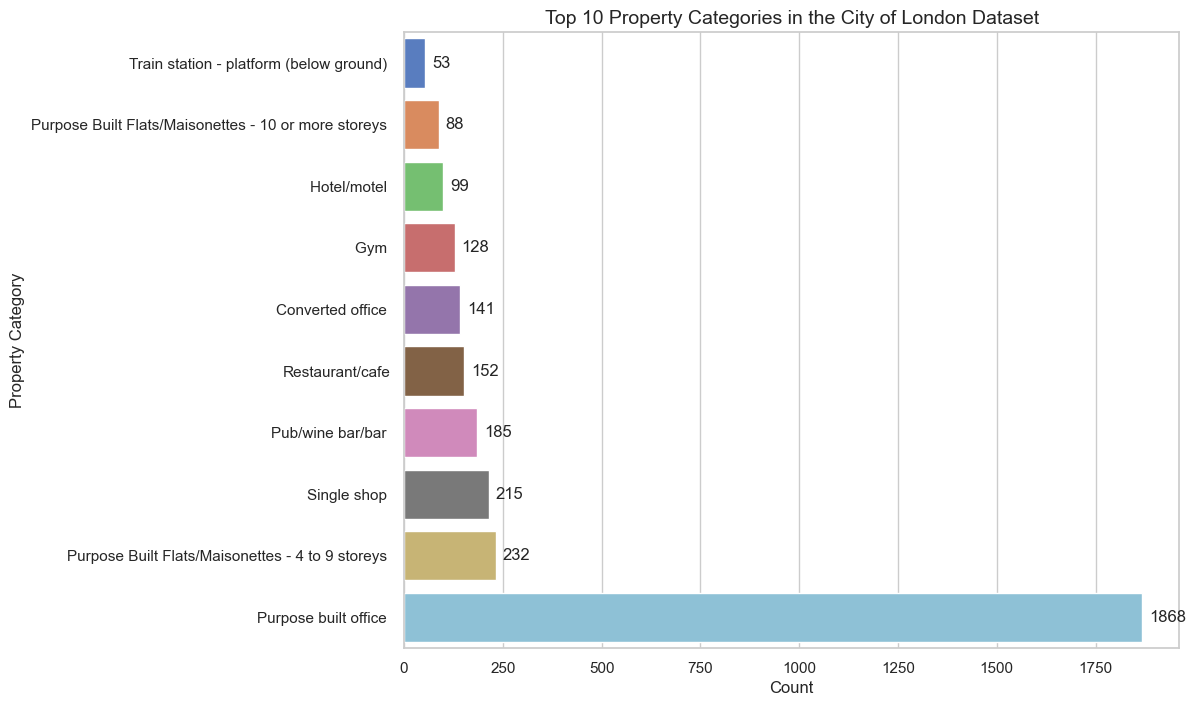

Top 10 Property Categories in the City of London Dataset:
PropertyType
Train station - platform (below ground)                    53
Purpose Built Flats/Maisonettes - 10 or more storeys       88
Hotel/motel                                                99
Gym                                                       128
Converted office                                          141
Restaurant/cafe                                           152
Pub/wine bar/bar                                          185
Single shop                                               215
Purpose Built Flats/Maisonettes - 4 to 9 storeys          232
Purpose built office                                     1868
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')

# Get the counts of each property category
property_counts = CityOfLondon[categorical_columns[6]].value_counts()

# Sort the property categories by count
property_counts = property_counts.sort_values()

# Define the number of top categories to show
top_n = 10  # Change this number as desired

# Get the top N property categories
top_categories = property_counts[-top_n:]

# Define a custom color palette
custom_palette = sns.color_palette('muted')

# Create the countplot of the PropertyCategory column
ax = sns.countplot(data=CityOfLondon, y=categorical_columns[6], palette=custom_palette, order=top_categories.index)
ax.set_title(f'Top {top_n} Property Categories in the City of London Dataset', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Property Category', fontsize=12)

# Add count values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'),
                xy=(p.get_width(), p.get_y() + p.get_height() / 2),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left',
                va='center')

plt.show()

# Print the values
print(f"Top {top_n} Property Categories in the City of London Dataset:")
print(top_categories)


# DATA QUALITY

# check for Redundant Columns

In [ ]:
CityOfLondon.columns


Index(['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall', 'HourOfCall',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS',
       'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_AttendanceTime',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'],
      dtype='object')

# columns to remove

In [ ]:
# Define columns to remove
redundant_columns = ['IncGeo_BoroughCode', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'FRS']
irrelevant_columns = ['UPRN', 'USRN']
privacy_columns = ['AddressQualifier', 'Postcode_full']
removeable_columns = redundant_columns + irrelevant_columns + privacy_columns

# Print the list of columns to remove
print("Columns to remove:")
for col in removeable_columns:
    print(f"- {col}")

# Remove columns from the City of London dataset
CityOfLondon = CityOfLondon.drop(columns=removeable_columns)
print("\nColumns removed!")


Columns to remove:
- IncGeo_BoroughCode
- ProperCase
- IncGeo_WardCode
- IncGeo_WardNameNew
- Easting_m
- Northing_m
- FRS
- UPRN
- USRN
- AddressQualifier
- Postcode_full

Columns removed!


#  Updating numerical_columns and categorical_columns

In [ ]:
# Update numerical_columns and categorical_columns for City of London dataset
numerical_columns = [col for col in CityOfLondon.columns if col not in removeable_columns and CityOfLondon[col].dtype != 'O']
categorical_columns = [col for col in CityOfLondon.columns if col not in removeable_columns and CityOfLondon[col].dtype == 'O']


In [ ]:
print("Numerical Columns: ", numerical_columns)
print("Categorical Columns: ", categorical_columns)

Numerical Columns:  ['DateOfCall', 'CalYear', 'HourOfCall', 'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']
Categorical Columns:  ['IncidentNumber', 'TimeOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation']


# missing values in each column of the dataset

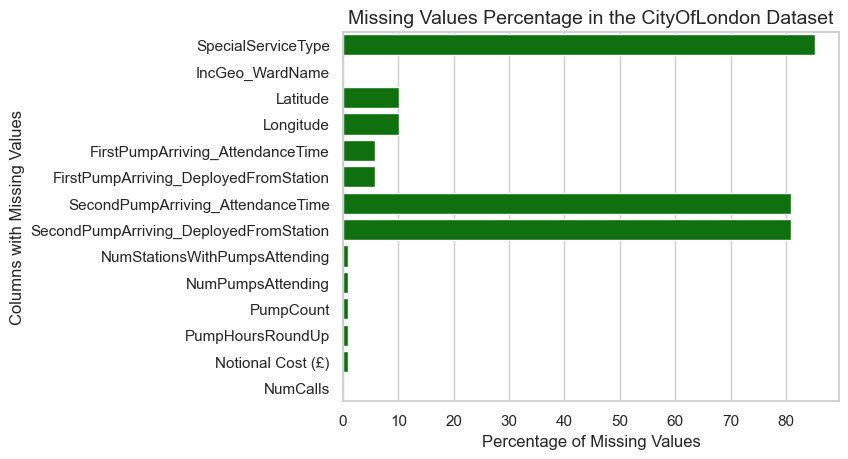

In [ ]:
missing = [(col, CityOfLondon[col].isna().sum()) for col in CityOfLondon.columns if CityOfLondon[col].isna().sum() > 0]
missing_x = [i[0] for i in missing]
missing_y = [(i[1] / len(CityOfLondon)) * 100 for i in missing]
sns.set_style('whitegrid')
sns.barplot(x=missing_y, y=missing_x, color='green')  # Change color to green
plt.xlabel('Percentage of Missing Values', fontsize=12)
plt.ylabel('Columns with Missing Values', fontsize=12)
plt.title('Missing Values Percentage in the CityOfLondon Dataset', fontsize=14)
plt.show()


In [ ]:
# Create a list of columns with one or more missing values
missing_1plus = CityOfLondon.columns[CityOfLondon.isna().sum() >= 1]

# Get the count of columns with one or more missing values
count_missing_1plus = len(missing_1plus)

# Print the count of columns with one or more missing values
print("Number of columns with one or more missing values:", count_missing_1plus)

# Get number of missing values for each column
missing_values = CityOfLondon.isnull().sum()

# Print missing values for each column
print("Number of missing values for each column:")
print(missing_values)


Number of columns with one or more missing values: 14
Number of missing values for each column:
IncidentNumber                               0
DateOfCall                                   0
CalYear                                      0
TimeOfCall                                   0
HourOfCall                                   0
IncidentGroup                                0
StopCodeDescription                          0
SpecialServiceType                        3506
PropertyCategory                             0
PropertyType                                 0
Postcode_district                            0
IncGeo_BoroughName                           0
IncGeo_WardName                              1
Easting_rounded                              0
Northing_rounded                             0
Latitude                                   416
Longitude                                  416
IncidentStationGround                        0
FirstPumpArriving_AttendanceTime           240
FirstPumpAr

In [ ]:
from sklearn.impute import SimpleImputer

# Identify numerical and categorical columns
numerical_columns = [col for col in RichmondUponThames.columns if col not in removeable_columns and RichmondUponThames[col].dtype != 'O' and RichmondUponThames[col].dtype != '<M8[ns]']
categorical_columns = [col for col in RichmondUponThames.columns if col not in removeable_columns and RichmondUponThames[col].dtype == 'O']

# Create an instance of SimpleImputer with the 'mean' strategy for numerical columns
imputer_num = SimpleImputer(strategy='mean')

# Fit and transform numerical columns
RichmondUponThames[numerical_columns] = imputer_num.fit_transform(RichmondUponThames[numerical_columns])

# Create an instance of SimpleImputer with the 'most_frequent' strategy for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')

# Fit and transform categorical columns
RichmondUponThames[categorical_columns] = imputer_cat.fit_transform(RichmondUponThames[categorical_columns])


In [ ]:
from sklearn.impute import SimpleImputer

# Identify numerical and categorical columns
numerical_columns = [col for col in CityOfLondon.columns if col not in removeable_columns and CityOfLondon[col].dtype != 'O' and CityOfLondon[col].dtype != '<M8[ns]']
categorical_columns = [col for col in CityOfLondon.columns if col not in removeable_columns and CityOfLondon[col].dtype == 'O']

# Create an instance of SimpleImputer with the 'mean' strategy for numerical columns
imputer_num = SimpleImputer(strategy='mean')

# Fit and transform numerical columns
CityOfLondon[numerical_columns] = imputer_num.fit_transform(CityOfLondon[numerical_columns])

# Create an instance of SimpleImputer with the 'most_frequent' strategy for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')

# Fit and transform categorical columns
CityOfLondon[categorical_columns] = imputer_cat.fit_transform(CityOfLondon[categorical_columns])

# Check for missing values
missing_values = CityOfLondon.isna().sum()

# Print the count of missing values in each column
print("Count of missing values in each column:")
print(missing_values)


Count of missing values in each column:
IncidentNumber                            0
DateOfCall                                0
CalYear                                   0
TimeOfCall                                0
HourOfCall                                0
IncidentGroup                             0
StopCodeDescription                       0
SpecialServiceType                        0
PropertyCategory                          0
PropertyType                              0
Postcode_district                         0
IncGeo_BoroughName                        0
IncGeo_WardName                           0
Easting_rounded                           0
Northing_rounded                          0
Latitude                                  0
Longitude                                 0
IncidentStationGround                     0
FirstPumpArriving_AttendanceTime          0
FirstPumpArriving_DeployedFromStation     0
SecondPumpArriving_AttendanceTime         0
SecondPumpArriving_DeployedFromStati

# Duplicate Values


There are 0 duplicate rows in the dataset.


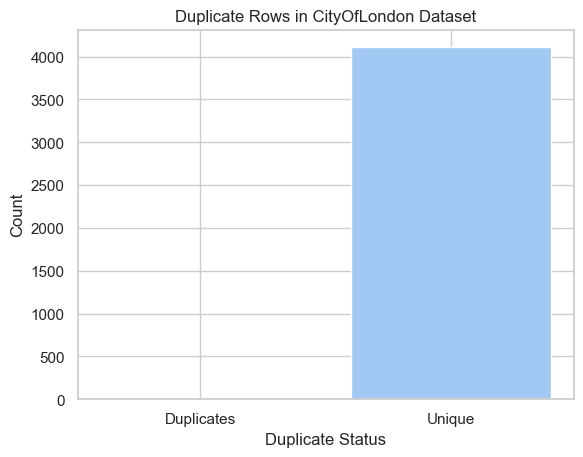

In [ ]:
# Print number of duplicates
print(f"There are {len(duplicates)} duplicate rows in the dataset.")

# Count the number of duplicate rows
num_duplicates = len(CityOfLondon[CityOfLondon.duplicated()])

# Create a bar plot
plt.bar(['Duplicates', 'Unique'], [num_duplicates, len(CityOfLondon)-num_duplicates])
plt.title('Duplicate Rows in CityOfLondon Dataset')
plt.xlabel('Duplicate Status')
plt.ylabel('Count')
plt.show()


# Check for Outliers in Numerical Columns

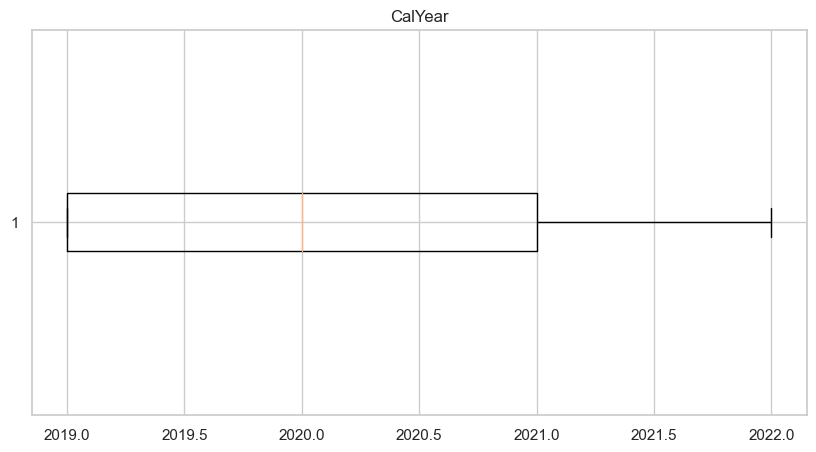

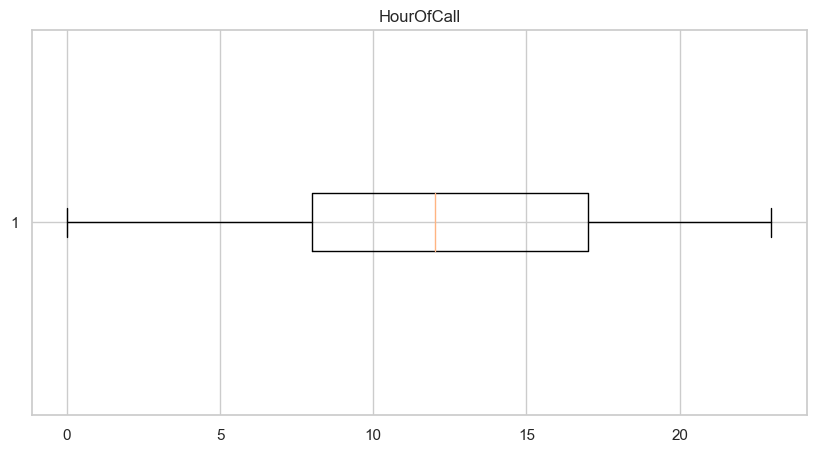

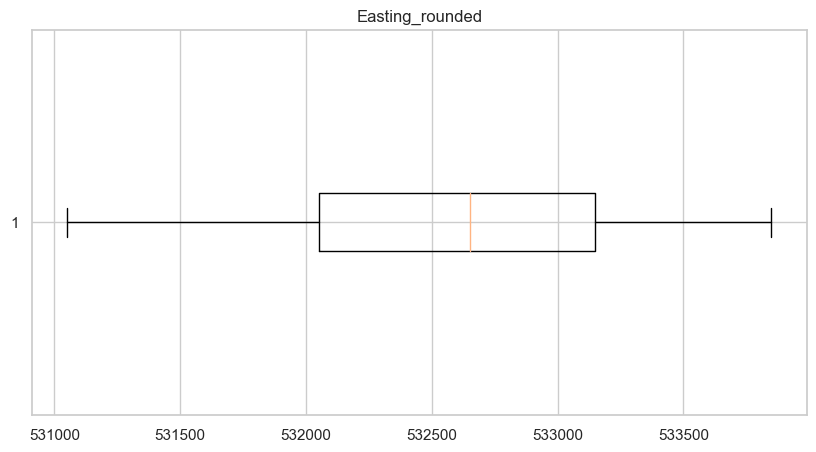

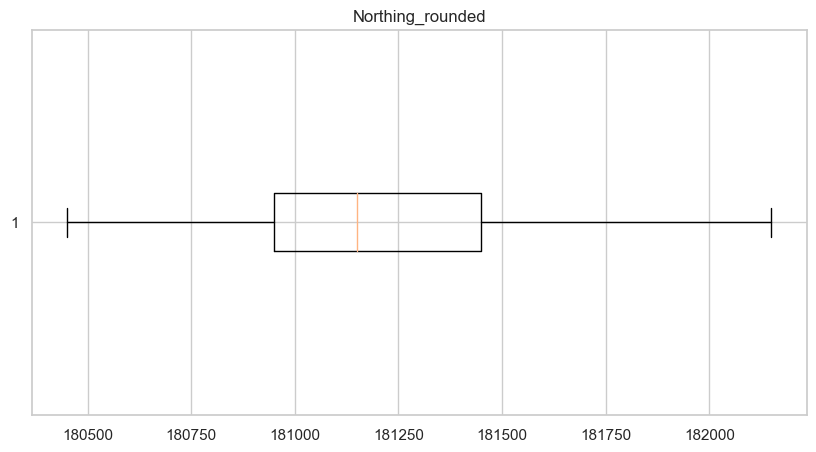

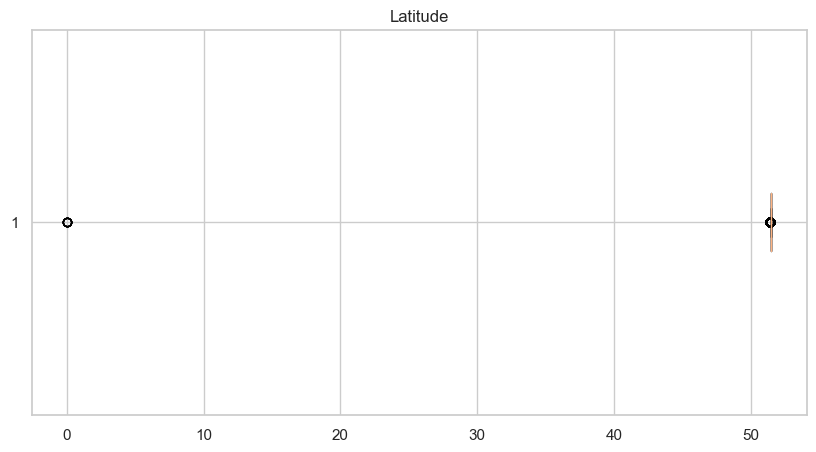

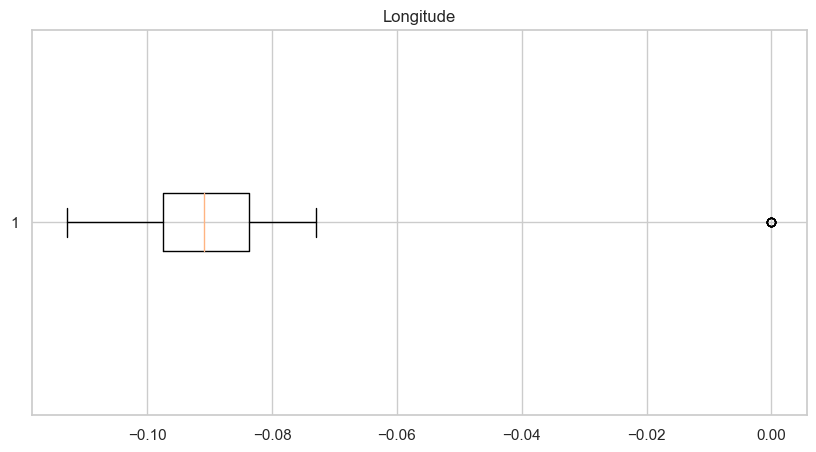

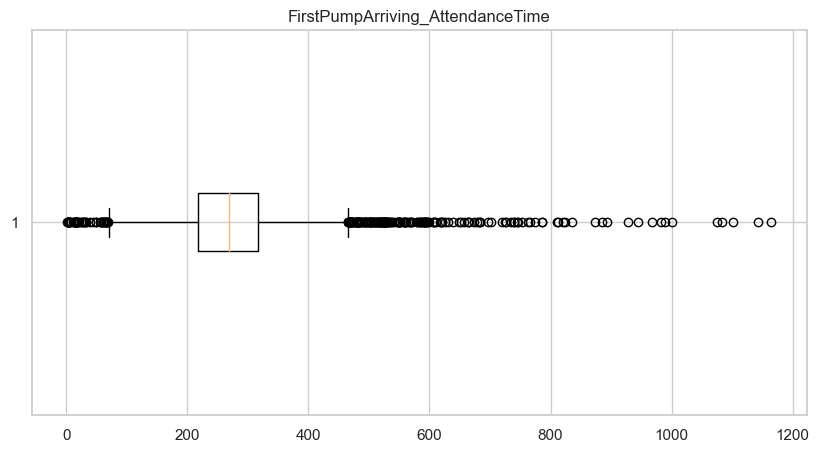

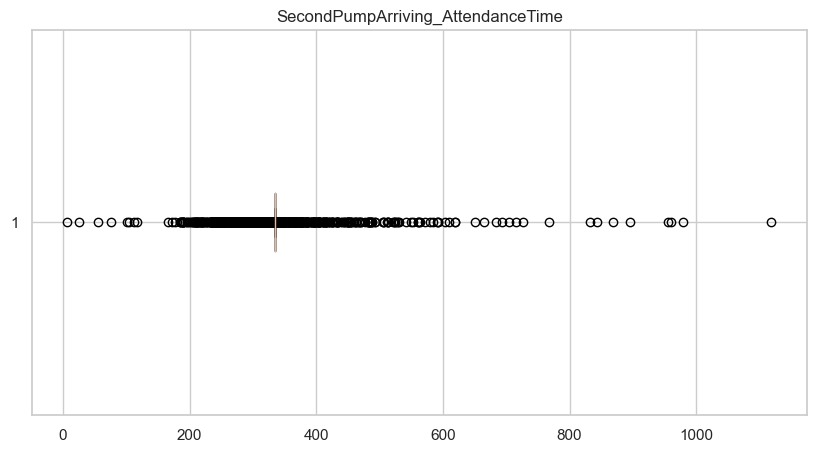

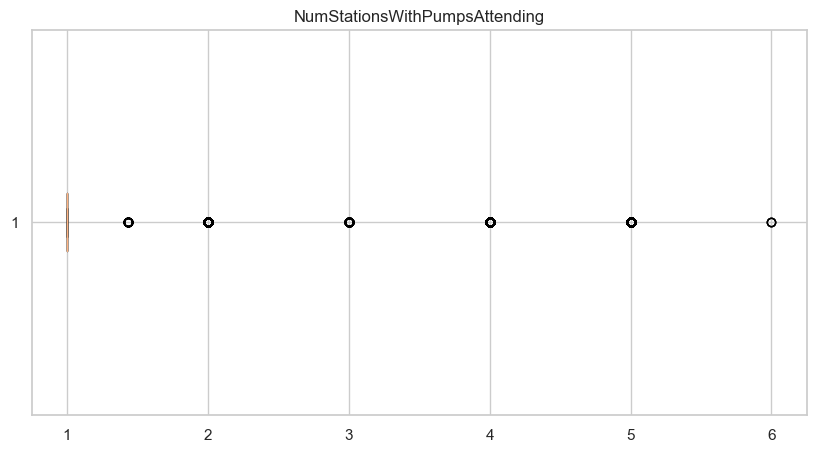

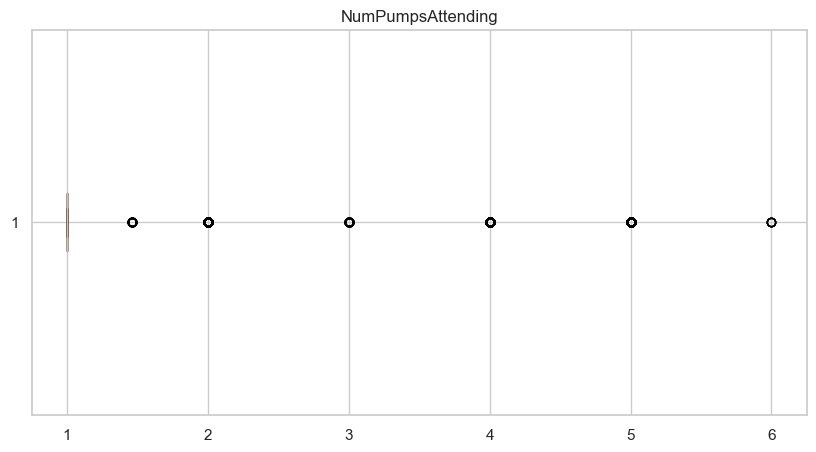

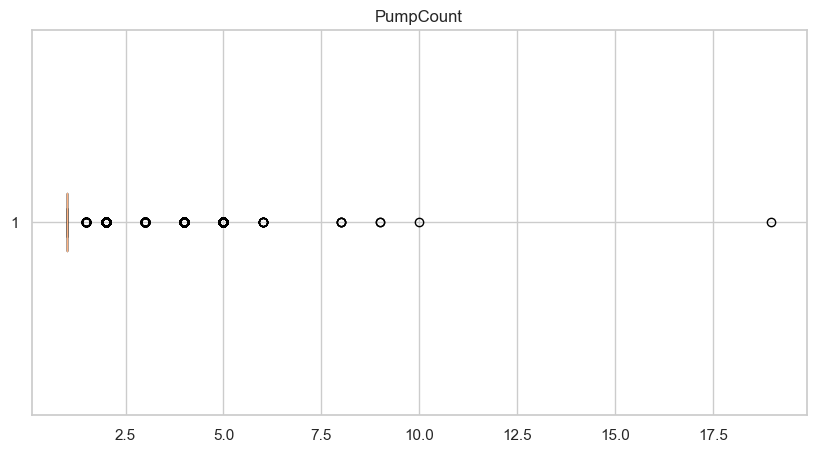

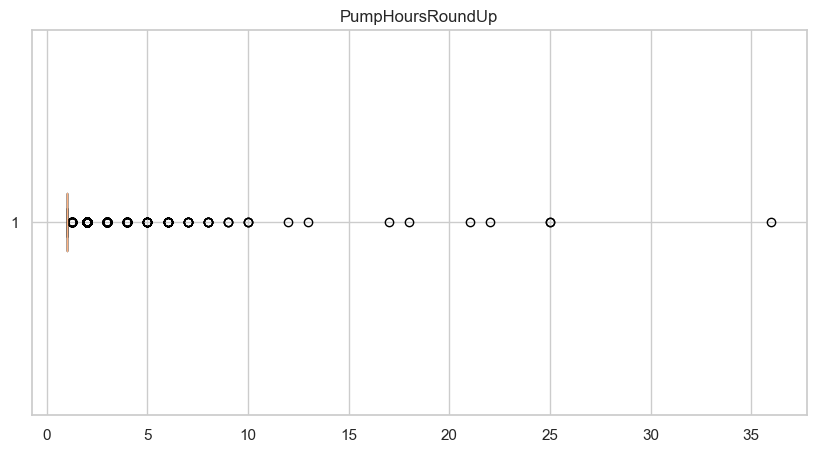

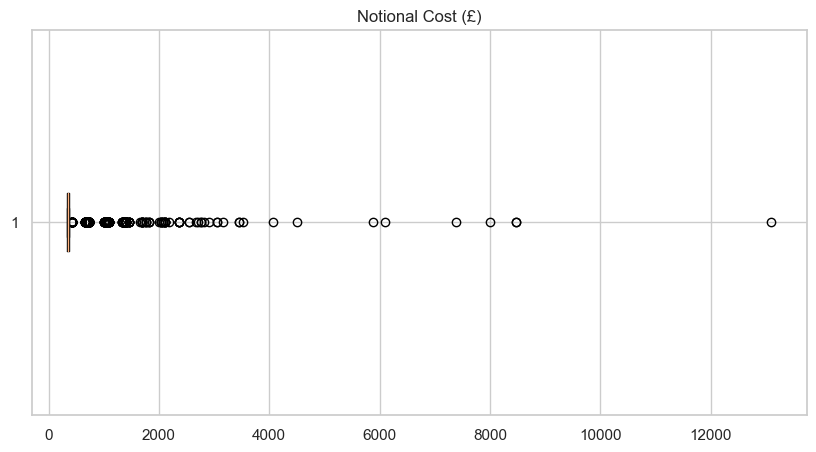

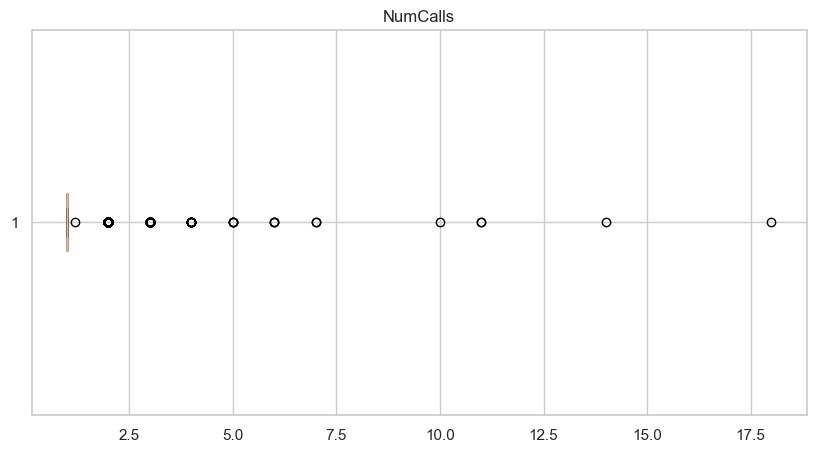

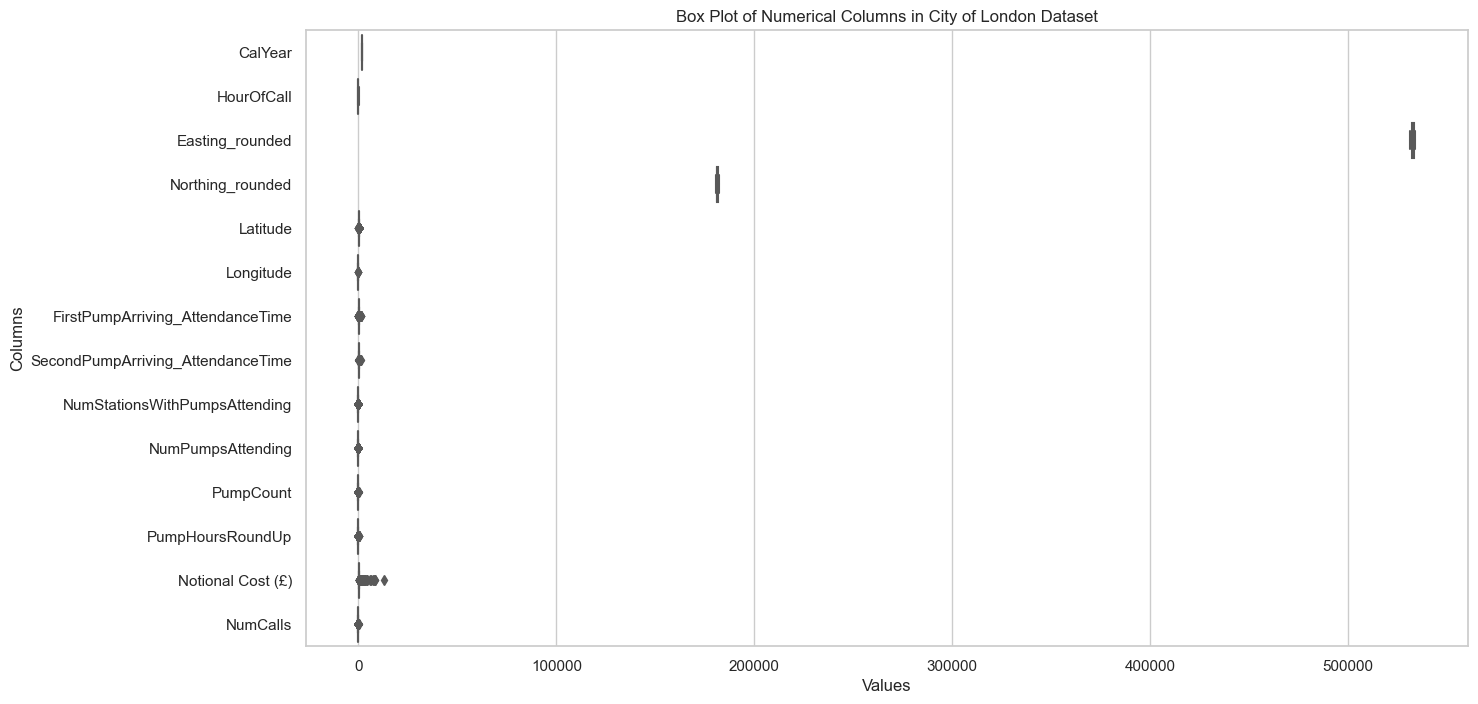

Outliers in CalYear: Series([], Name: CalYear, dtype: float64)
Outliers in HourOfCall: Series([], Name: HourOfCall, dtype: float64)
Outliers in Easting_rounded: Series([], Name: Easting_rounded, dtype: float64)
Outliers in Northing_rounded: Series([], Name: Northing_rounded, dtype: float64)
Outliers in Latitude: 19      51.416748
38      51.416748
75      51.416748
90      51.416748
104     51.416748
          ...    
4035    51.416748
4046    51.416748
4061    51.416748
4099    51.416748
4100    51.416748
Name: Latitude, Length: 423, dtype: float64
Outliers in Longitude: 647     0.0
963     0.0
1280    0.0
1323    0.0
2096    0.0
3354    0.0
3873    0.0
Name: Longitude, dtype: float64
Outliers in FirstPumpArriving_AttendanceTime: 20      516.0
24      526.0
57       65.0
58       19.0
80      518.0
        ...  
4071    531.0
4088     60.0
4089    468.0
4099    562.0
4100    740.0
Name: FirstPumpArriving_AttendanceTime, Length: 240, dtype: float64
Outliers in SecondPumpArriving_Attend

In [ ]:
# Create a box plot for each numerical column
for column in numerical_columns:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(CityOfLondon[column], vert=False)
    ax.set_title(column)
    plt.show()

# Define a function to find outliers
def find_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

plt.figure(figsize=(15, 8))
sns.boxplot(data=CityOfLondon[numerical_columns], orient='h', palette='Set2')
plt.title('Box Plot of Numerical Columns in City of London Dataset')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()


# Print outliers for each numerical column
for column in numerical_columns:
    outliers = find_outliers(CityOfLondon[column])
    print(f"Outliers in {column}:", outliers)


In [ ]:
# Define the Tukey's method to detect outliers
def tukey_method(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (col < lower_bound) | (col > upper_bound)

# Create a DataFrame to store the outliers
outliers_df = pd.DataFrame()

# Loop through each numerical column
for col in numerical_columns:
    # Use Tukey's method to detect the outliers
    outliers = tukey_method(RichmondUponThames[col])
    # Add the outliers to the DataFrame
    outliers_df[col] = outliers

# Print the number of outliers for each numerical column
print("Number of outliers:")
print(outliers_df.sum())


Number of outliers:
CalYear                                0
HourOfCall                             0
Easting_rounded                        0
Northing_rounded                       0
Latitude                               7
Longitude                              7
FirstPumpArriving_AttendanceTime     196
SecondPumpArriving_AttendanceTime     52
NumStationsWithPumpsAttending        781
NumPumpsAttending                    804
PumpCount                            828
PumpHoursRoundUp                     453
Notional Cost (£)                    453
NumCalls                             621
dtype: int64


In [ ]:
# Define the list of columns where we want to remove outliers based on the given outlier counts
outlier_columns = ['Latitude', 'Longitude', 'FirstPumpArriving_AttendanceTime',
                   'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending',
                   'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']

# Loop through each numerical column
for col in numerical_columns:
    # Only remove the outliers in the specified columns with outliers
    if col in outlier_columns:
        outliers = tukey_method(CityOfLondon[col])
        CityOfLondon = CityOfLondon[~outliers]

# Verify that outliers are removed
print("Number of outliers after removal:")
for col in outlier_columns:
    outliers_count = tukey_method(CityOfLondon[col]).sum()
    print(f"{col}: {outliers_count}")


Number of outliers after removal:
Latitude: 0
Longitude: 0
FirstPumpArriving_AttendanceTime: 34
SecondPumpArriving_AttendanceTime: 0
NumStationsWithPumpsAttending: 0
NumPumpsAttending: 0
PumpCount: 0
PumpHoursRoundUp: 0
Notional Cost (£): 0
NumCalls: 0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Loop through the categorical columns and apply the LabelEncoder
for col in categorical_columns:
    CityOfLondon[col] = le.fit_transform(CityOfLondon[col])


In [ ]:
print(CityOfLondon[categorical_columns].head())



   IncidentNumber  TimeOfCall  IncidentGroup  StopCodeDescription  \
0               4         835              0                    0   
1               5        1819              0                    0   
2              10         134              1                    5   
4              12         514              0                    0   
6              13        1560              0                    0   

   SpecialServiceType  PropertyCategory  PropertyType  Postcode_district  \
0                   5                 0            78                 19   
1                   5                 0            68                 23   
2                   5                 2            73                 18   
4                   5                 0            49                 19   
6                   5                 0            68                 10   

   IncGeo_BoroughName  IncGeo_WardName  IncidentStationGround  \
0                   0               17                      0  

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Instantiating the MinMaxScaler object
scaler = MinMaxScaler()

# Fitting and transforming the selected columns
CityOfLondon[numerical_columns] = scaler.fit_transform(CityOfLondon[numerical_columns])

In [ ]:
print(CityOfLondon[numerical_columns].head())

   CalYear  HourOfCall  Easting_rounded  Northing_rounded  Latitude  \
0      0.0    0.434783         0.250000          0.400000  0.403268   
1      0.0    0.739130         0.178571          0.333333  0.352727   
2      0.0    0.086957         0.142857          0.466667  0.447818   
4      0.0    0.347826         0.285714          0.400000  0.438102   
6      0.0    0.652174         0.428571          0.466667  0.450296   

   Longitude  FirstPumpArriving_AttendanceTime  \
0   0.266481                          0.630273   
1   0.175131                          0.501241   
2   0.138554                          0.526055   
4   0.280695                          0.384615   
6   0.431994                          0.538462   

   SecondPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  \
0                                0.0                            0.0   
1                                0.0                            0.0   
2                                0.0                       

# 1.Identifying high-risk areas: Analyzing the location and type of fire incidents in Waltham Forest could help identify areas that are at higher risk of fire incidents, allowing the local fire department to prioritize their resources accordingly.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Select relevant columns
X = RichmondUponThames[['PropertyCategory', 'PropertyType', 'Postcode_district', 'IncidentGroup']]
y = RichmondUponThames['IncidentGroup']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Evaluate performance
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00       205

    accuracy                           1.00       342
   macro avg       1.00      1.00      1.00       342
weighted avg       1.00      1.00      1.00       342



# 2.	Response time optimization: Analyzing the response times of the fire department to incidents could help identify factors that contribute to longer response times and identify potential solutions for optimizing response times.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Select relevant columns
X = RichmondUponThames[['PropertyCategory', 'PropertyType', 'Postcode_district', 'IncidentGroup', 'TimeOfCall', 'CalYear', 'FirstPumpArriving_DeployedFromStation', 'FirstPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp']]
y = RichmondUponThames['FirstPumpArriving_AttendanceTime']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize linear regression model
model = LinearRegression()

# Fit model to training data
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared score: ", r2)
print("Mean squared error: ", mse)


R-squared score:  1.0
Mean squared error:  2.766955253446257e-31


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of incident counts by postcode district
plt.figure(figsize=(10,6))
sns.countplot(x='Postcode_district', data=WalthamForest, palette='rocket')
plt.title('Incidents by Postcode District', fontsize=16)
plt.xlabel('Postcode District', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Bar plot of incident counts by property category
plt.figure(figsize=(10,6))
sns.countplot(x='PropertyCategory', data=WalthamForest, palette='rocket')
plt.title('Incidents by Property Category', fontsize=16)
plt.xlabel('Property Category', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)
plt.show()

# Bar plot of incident counts by property type
plt.figure(figsize=(10,6))
sns.countplot(x='PropertyType', data=WalthamForest, palette='rocket')
plt.title('Incidents by Property Type', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Bar plot of incident counts by incident group
plt.figure(figsize=(10,6))
sns.countplot(x='IncidentGroup', data=WalthamForest, palette='rocket')
plt.title('Incidents by Incident Group', fontsize=16)
plt.xlabel('Incident Group', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()
